In [32]:
import os
import sys # for debugging
import numpy as np

import re

import math

from scipy.optimize import minimize
import pickle

In [12]:
file=open("C:/Users/adith/Downloads/handwriting Dataset/ascii-all.txt","r")
#print(file.readline())
sample=file.readlines()#list of lines(upto any \n) as strings 
mytext=''.join(sample)#gigantic string of text

mypattern=re.compile('CSR:[ ]?\n\n(.|\n)+?(\n    |ascii)')
mymatches=mypattern.finditer(mytext)
labels=[m.group(0)[6:-5].replace('\n',' ').rstrip() for m in mymatches]#removes the predictable excess chars|(replacements done)
len(labels) #list of strings that give groundTruth for the handwriting data
#labels[-100:] shows some errors 'nike just do it'? I don't know what's happening there

1907

In [13]:
#now we get all the headers from the label dataset (we will use this to match with the strokeset dataset)

delpatt2=re.compile(r"ascii(?P<textpath>/.../...-.../...-...(.)?)[.]txt")
delmatches2=delpatt2.finditer(mytext)
lstoftextpaths=[m.group('textpath') for m in delmatches2]
print(len(lstoftextpaths))
print(lstoftextpaths[0:10]) #looks good

#now we combine the textHeaders and the textLabels into --> (.,.) using zip
headed_labels=list(zip(lstoftextpaths,labels)) #looks good

1907
['/a01/a01-000/a01-000u', '/a01/a01-000/a01-000x', '/a01/a01-001/a01-001w', '/a01/a01-001/a01-001z', '/a01/a01-003/a01-003', '/a01/a01-003/a01-003x', '/a01/a01-004/a01-004', '/a01/a01-004/a01-004w', '/a01/a01-007/a01-007', '/a01/a01-007/a01-007w']


In [14]:
file2=open("C:/Users/adith/Downloads/handwriting Dataset/lineStrokes-all.txt","r")
sample2=file2.readlines()
mytext2=''.join(sample2)

In [15]:
#now we get all the headers from the stroke dataset (we will use this to match with the label dataset)

patforstrokeheader=re.compile(r"lineStrokes(?P<strokepath>/.../...-.../...-...[^\n-]?)-?(?P<subpath>.*)[.]xml")
matchesforstrokeheader=patforstrokeheader.finditer(mytext2)
lstofstrokepaths=[(m.group('strokepath'),m.group('subpath')) for m in matchesforstrokeheader]
print('the length of strokePaths is:',len(lstofstrokepaths),"\n")
print("sample:",lstofstrokepaths[0:10],"\n")
      

#headed_strokes...... this will have to wait...

the length of strokePaths is: 12195 

sample: [('/a01/a01-000/a01-000u', '01'), ('/a01/a01-000/a01-000u', '02'), ('/a01/a01-000/a01-000u', '03'), ('/a01/a01-000/a01-000u', '04'), ('/a01/a01-000/a01-000u', '05'), ('/a01/a01-000/a01-000u', '06'), ('/a01/a01-001/a01-001w', '01'), ('/a01/a01-001/a01-001w', '02'), ('/a01/a01-001/a01-001w', '03'), ('/a01/a01-001/a01-001w', '04')] 



In [16]:
#deletable cell

#check for number of unique super paths in strokes
set_of_super_stroke_paths=set([i for i,j in lstofstrokepaths])
list_of_super_stroke_paths=list[set_of_super_stroke_paths]

print("only these headers have companions in the <labels> so this is the max examples...",len(set_of_super_stroke_paths),'\n')
set_of_text_paths=set(lstoftextpaths)
print('length of text paths:',len(set_of_text_paths),'\n')
missing_stroke_paths=set_of_text_paths-set_of_super_stroke_paths
print('number of missing paths:',len(missing_stroke_paths))

#deletable cell
print('some missing paths:',list(missing_stroke_paths)[:10]) #the follwing are in text paths but not in stroke paths

only these headers have companions in the <labels> so this is the max examples... 1730 

length of text paths: 1907 

number of missing paths: 177
some missing paths: ['/a01/a01-020/a01-020', '/c03/c03-000/c03-000f', '/a03/a03-068/a03-068', '/d03/d03-112/d03-112', '/f04/f04-039/f04-039', '/h04/h04-064/h04-064', '/a04/a04-066/a04-066', '/a02/a02-062/a02-062a', '/f04/f04-074/f04-074', '/z00/z00-000/z00-000a']


In [17]:
tagpattern1=re.compile(r"<StrokeSet>((.|\n)*?)</StrokeSet>")
tagmatches1=tagpattern1.finditer(mytext2)
listofstrokesets=[strokeset.group(1) for strokeset in tagmatches1]#[ 'strokeset', 'strokeset' ]

def extract_strokes_and_points(strokeset):
    tagpattern2=re.compile(r'<Stroke(.)+>(?P<strk>(.|\n)*?)</Stroke>')
    tagmatches2=tagpattern2.finditer(strokeset)
    LoStrokes=[stroke.group('strk') for stroke in tagmatches2]
    return [extract_points(stroke) for stroke in LoStrokes]
    
def extract_points(stroke):
    tagpattern3=re.compile(r'<Point (?P<pnt>(.)*?)/>')
    tagmatches3=tagpattern3.finditer(stroke)
    LoPoints=[lop.group('pnt') for lop in tagmatches3]
    return [extract_tuples(p) for p in LoPoints]

def extract_tuples(point):
    tagpattern4=re.compile(r'=["](\d|.)*?["]')
    tagmatches4=tagpattern4.finditer(point)
    return tuple([float(m.group(0)[2:-1]) for m in tagmatches4])
    
    

lo_tups=[extract_strokes_and_points(strokeset) for strokeset in listofstrokesets] #(x,y,t) tuples

#the final dataset to use 
#headed_strokes....the wait is over!...
#lo_tups.len()=lstofstrokepaths.len()=12195


headed_strokes=list(zip(lstofstrokepaths,lo_tups))

In [18]:
# headed_strokes[0] == ((path,subpath),[strokeSet])

print('number of strokesets/path+subPaths:',len(headed_strokes))
# now we need (labelstring,strokesetList)
#(.,.)
#(string,list)

# headed_labels[0] =path,labelstring
# headed_strokes[0] = (p,sp),strokeset

#if path=p: strokeset.extend(ss) for ss in headed_strokes[:][p==path,:]
# should have 1730 labelString-strokeset pairs

headed_dict={} #headed dictionary {p:{sp:ss,...},...   }
for (p,sp),ss in headed_strokes:
    if p in headed_dict.keys():
        headed_dict[p][sp]=ss #if path exists make (subpath:strokeset) a new entry of the subdictionary under it(ie.:<sp>)
    else:
        headed_dict[p]={sp:ss}
for p,d in headed_dict.items():
    loss=[ss for sp,ss in sorted(d.items(),key=lambda x:int((x[0])))] #the <sp> is a string_object
    newd=[]
    for ss in loss:
        newd.extend(ss) #the path's strokeset is extended by the strokes within each <ss> in <loss>
    headed_dict[p]=newd #the path is assigned a new, longer, stroke_set
print(len(headed_dict.keys()))

number of strokesets/path+subPaths: 12195
1730


In [19]:
#headed_dict # (p,ss+),.. is one item in dict
print('number of strokeset_paths in head_dic:',len(headed_dict.keys())) #there are 1730 paths. exactly as required.

#now time to get 1730 (label,ss+) pairs as a [(l,ss+),...]
#map p-p from (p,label) and (p,ss+) headed_labels
mapped_l_ss=[(label,headed_dict.get(path)) for path,label in headed_labels if path in headed_dict.keys()]
len(mapped_l_ss) #1730

number of strokeset_paths in head_dic: 1730


1730

In [19]:
import os

import numpy as np
import sys #for debugging
import re

import math

from scipy.optimize import minimize
import pickle

with open('mapped_l_ss.pkl', 'rb') as file:
    mapped_l_ss = pickle.load(file)


import tkinter as tk
stroke_tracker=0
import random

xandy=mapped_l_ss[10][1]

rcolours=[
"#F0F8FF"
,"#FAEBD7"
,"#00FFFF"
,"#007FFF"
,"#E3CF57"
,"#FFEBCD"
,"#8A2BE2"
,"#CD3333"]

scale=1000
scaley=200

class DrawingApp:
    global stroke_tracker, rcolours, scale, scaley
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Drawing App")

        # Create a Canvas widget to draw on
        self.canvas = tk.Canvas(root, bg="white", width=1400, height=800)
        self.canvas.pack()
        
        #my addition , deletable
        #self.canvas.bind("<ButtonRelease-1>", self.stop_drawing)

        # Bind mouse events to canvas
        self.canvas.bind("<Button-1>", self.start_drawing)
        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonRelease-1>", self.stop_drawing)

        # Initialize drawing variables
        self.drawing = True
        self.last_x = None
        self.last_y = None

    def start_drawing(self, event):
        self.drawing = True
        self.last_x = event.x
        self.last_y = event.y
        
    def change_colour(self):
        temp=str(hex(random.randrange(0, 2**24)))
        temp=temp[2:]
        temp='#'+temp
        self.colour= random.choice(rcolours)

    def draw(self, event):
        if self.drawing:
            for stroke in xandy:
                self.change_colour()
                self.last_x= stroke[0][0]*scale
                self.last_y= stroke[0][1]*scaley
                for point in stroke:
                    x, y = point[0]*scale,point[1]*scaley
                    self.canvas.create_line(self.last_x, self.last_y, x, y, fill=self.colour, width=2)
                    self.last_x = x
                    self.last_y = y

    def stop_drawing(self, event):
        self.drawing = False
        self.last_x = None
        self.last_y = None

if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()


# Main Class For Handwriting cleaning



In [ ]:
class INTR_PERS():
    def __init__(self,for_me=[]):
        self.dic={'data':for_me,'indexes to consider':[]}
        self.prev_bez=[]
        self.new_data=[]
    def get_candidate(self):
        candidate=[]
        for i in self.dic['indexes to consider']:
            
            candidate.extend(self.dic.get('data')[i])
        return candidate
    def funnel(self):
        if not len(self.prev_bez)==10:
            
        if self.prev_bez==[]:
            pass
        else:
            self.new_data.append(self.prev_bez)

In [181]:
#time to work on bezier strokes! make at least one!! think about it!!!
import numpy as np
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
error_log=[]

class B_Z():
    global error_log
    def __init__(self,is_introspective=False,NullIfFail=False):
        self.is_introspective=is_introspective
        self.nulliffail=NullIfFail
        
        self.bezier_beads_args=[] #everytime this is changed please use b_b_sort()
        self.bezier_beads=[]
        #self.bezier_beads_sort() #s belongs to [0,1] #this deserves to be ccommented out..
        self.stroke_matrix=[]
        self.prevSSE=[]
        [[self.alpha0,self.beta0,self.gamma0],
         [self.alpha1,self.beta1,self.gamma1],
         [self.alpha2,self.beta2,self.gamma2],
         [self.alpha3,self.beta3,self.gamma3]]=np.zeros((4,3))
        self.p=np.array([[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]])
        
        self.hyper_newton_steps=20 #number of newton steps to run per bezier bead re-adjust
        self.hyper_numb_of_fits=20 #number of attempts to find OMEGA, bezier fit for the stroke
        #self.SSEmaxThr=1e-4
        self.SSEmaxThr=1e-5 #commented out for ssemax v. legibility test ###
        #self.SSEmaxThr=1e-4
        #self.SSEmaxThr=1e-3 ###legibility check #this seems good to me
        #self.SSEmaxThr=1e-2 ###legibility check
        #self.SSEmaxThr=1e-1 ###legibility check 
        #self.SSEmaxThr=1e-0 ###legibility check 
        #self.SSEmaxThr=0.9
        #self.SSEdeltaMin=1e-9
        
        
    def bezier_beads_sort(self):
        a1=self.bezier_beads_args
        a0=a1**0
        a2=a1**2
        a3=a1**3
        self.bezier_beads=np.array([a0,a1,a2,a3]).T

    def get_omega(self):
        return [[self.alpha0,self.beta0,self.gamma0],
         [self.alpha1,self.beta1,self.gamma1],
         [self.alpha2,self.beta2,self.gamma2],
         [self.alpha3,self.beta3,self.gamma3]]
        
    def strokelength(self,stroke,deduper=False):
        if deduper:
            stroke=self.deduplicate_stroke(stroke)
        #this is just a list of tups let's make it an array of shape (n,3)
        self.stroke_matrix=np.array(stroke)
        if len(self.stroke_matrix.shape)<=1:
            
            error_log.append({'type':'inside',
                              'at':['strokelength'],
                              'comment':'⚠️ why is stroke_matrix so small? shape:'+str(self.stroke_matrix.shape)+'\n'+'⚠️ s.stroke_matrix:'+str(self.stroke_matrix)})
            
            
            
            
            #it shouldn't be possible to have such a small stroke matrix because you can't cut strokes of length 2 any smaller..
            #the only case for stroke matrix to be length=1 is if it comes directly from the dataset..

        arc=self.stroke_matrix
        self.stroke_length=sum(((arc[:,0][1:]-arc[:,0][:-1])**2+(arc[:,1][1:]-arc[:,1][:-1])**2)**0.5)
        self.bezier_beads_args=np.linspace(0,1,self.stroke_matrix.shape[0])
        self.bezier_beads_sort()
        return self.stroke_matrix,self.stroke_length

    def update_omega(self,omega):
        [[self.alpha0,self.beta0,self.gamma0],
         [self.alpha1,self.beta1,self.gamma1],
         [self.alpha2,self.beta2,self.gamma2],
         [self.alpha3,self.beta3,self.gamma3]]=omega
        
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
 
    def x_of_s(self,s):
        return self.alpha0+self.alpha1*s+self.alpha2*s*s+self.alpha3*s*s*s
    def xprime_of_s(self,s):
        return self.alpha1+2*self.alpha2*s+3*self.alpha3*s*s
    def xprimeprime_of_s(self,s):
        return 2*self.alpha2+6*self.alpha3*s
    def y_of_s(self,s):
        return self.beta0+self.beta1*s+self.beta2*s*s+self.beta3*s*s*s
    def yprime_of_s(self,s):
        return self.beta1+2*self.beta2*s+3*self.beta3*s*s
    def yprimeprime_of_s(self,s):
        return 2*self.beta2+6*self.beta3*s
    def t_of_s(self,s):
        return self.gamma0+self.gamma1*s+self.gamma2*s*s+self.gamma3*s*s*s
    def f_of_s(self,s,xi,yi):
        return self.xprime_of_s(s)*(xi - self.x_of_s(s)) + self.yprime_of_s(s)*(yi - self.y_of_s(s))
    def fprime_of_s(self,s,xi,yi):
        return xi*self.xprimeprime_of_s(s)-self.xprimeprime_of_s(s)*self.x_of_s(s)-self.xprime_of_s(s)**2+yi*self.yprimeprime_of_s(s)-self.yprimeprime_of_s(s)*self.y_of_s(s)-self.yprime_of_s(s)**2

    def newton_step_2(self,si,xi,yi):
        #xnew=si
        for _ in range(self.hyper_newton_steps):
            if self.f_of_s(si,xi,yi)<1e-5:
                break
            #xnew=xnew-self.f_of_s(si,xi,yi)/self.fprime_of_s(si,xi,yi) #absolute rubbish
            si=si-self.f_of_s(si,xi,yi)/self.fprime_of_s(si,xi,yi)
        return si#xnew #absolute rubbish
    def newton_step(self):
        for i,si in enumerate(self.bezier_beads_args):#there are [0:N-1] bezier beads, it's a matrix, b_b_args is a list
            self.bezier_beads_args[i]=self.newton_step_2(si,self.stroke_matrix[i][0],self.stroke_matrix[i][1])
        self.bezier_beads_sort()
    
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''

    def SSE(self,just_checking=False):
        
        f=self.bezier_beads@self.get_omega()
        f=self.stroke_matrix-f #.T removed..
        returner=np.sum(f**2)
        if not just_checking:
            self.prevSSE.append(returner)
        return returner

    def convergence(self):
        return False ### remove this if needed
        if len(self.prevSSE)<=1:
            return False
        if self.prevSSE[-1]-self.SSE(just_checking=True)<1e-10:
            
            error_log.append({'type':'inside',
                              'at':['convergence'],
                             'comment':'converged! difference: '+str(self.prevSSE[-1]-self.SSE(just_checking=True))+'\n last ten SSE'+str(self.prevSSE[-10:])
                             })
            
            '''
            print('converged!!! @ difference:',self.prevSSE[-1]-self.SSE(just_checking=True))
            print('converged!!! @ prevSSE last 10:',self.prevSSE[-10:])'''
        
        return self.prevSSE[-1]-self.SSE(just_checking=True)<1e-10 or self.SSE(just_checking=True)<self.SSEmaxThr
    
    def get_p(self):
        for i in [0,1]:
            a0,a1,a2,a3=np.array(self.get_omega())[:,i] #R 4,3
            self.p[0][i]=a0
            self.p[1][i]=(a1+3*a0)/3
            self.p[2][i]=(a2+3*a0+2*a1)/3
            self.p[3][i]=a0+a1+a2+a3
        return self.p #R 4,2
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
    '''                             🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
    def get_tenD(self):#returns ten d version of a given omega
        for i in [0,1]:
            a0,a1,a2,a3=np.array(self.get_omega())[:,i]
            self.p[0][i]=a0
            self.p[1][i]=(a1+3*a0)/3
            self.p[2][i]=(a2+3*a0+2*a1)/3
            self.p[3][i]=a0+a1+a2+a3
        #now to define all 10dimensions here:
        returner=[0,0,0,0,0,0,0,0,0,1]
        
        ### something dumb happended to self.p....
        '''print('@get_10D: self.p:',self.p)'''
        error_log.append({'type':'inside',
                              'at':['get_tenD'],
                             'comment':'self.p:'+str(self.p)
                             })
        
        #dx,dy
        returner[0],returner[1]= self.p[0]-self.p[3] 
        
        #d1,d2
        returner[2]=np.sum((self.p[1]-self.p[0])**2)**0.5
        returner[3]=np.sum((self.p[2]-self.p[3])**2)**0.5
        
        #alpha1,alpha2
        p01,p03=self.p[1]-self.p[0],self.p[3]-self.p[0]
        d01,d03=np.sum((p01)**2)**0.5,np.sum((p03)**2)**0.5
        
        
        if d01*d03 ==0:
            a0,a1,a2,a3=np.array(self.get_omega())[:,0]
            error_log.append({'type':'inside',
                              'at':['get_tenD','alpha 1'],
                             'comment':'d01*d03==0',
                              'state':{'d01':d01,
                                       'd03':d03,
                                       'p01':p01,
                                       'p03':p03,
                                       'p[1]':self.p[1],
                                       'p[0]':self.p[0],
                                       'p[3]':self.p[3],
                                       'a0':a0,
                                       'a1':a1,
                                       'a2':a2,
                                       'a3':a3,
                                       'self.stroke is singleton?':self.stroke_matrix
                                      }
                             })
        if (not d01*d03==0) and (np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1):
            a0,a1,a2,a3=np.array(self.get_omega())[:,0]
            error_log.append({'type':'inside',
                              'at':['get_tenD','alpha 1'],
                             'comment':'out of bounds, seriously wrong...:'+str((np.sum(p01*p03)/(d01*d03))),
                              'state':{'d01':d01,
                                       'd03':d03,
                                       'p01':p01,
                                       'p03':p03,
                                       'p[1]':self.p[1],
                                       'p[0]':self.p[0],
                                       'p[3]':self.p[3],
                                       'a0':a0,
                                       'a1':a1,
                                       'a2':a2,
                                       'a3':a3
                                      }
                             })
            
            
        
        
        
        '''if d01*d03 ==0 or np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1:
            if d01*d03 ==0:
                print('problem @ get_tenD() ..okay but fix it')
                print('alpha 1, d01:','「',d01,'」')
                print('alpha 1, d03:','「',d03,'」') #,'「',old_array,'」'    ,'」','「',old_array,
                print('alpha 1, p01:','「',p01,'」')
                print('alpha 1, p03:','「',p03,'」')
                print('alpha 1, p[1] & p[0]:','「',self.p[1],'」','「',self.p[0],'」')
                print('alpha 1, p[3]:','「',self.p[3],'」')
                a0,a1,a2,a3=np.array(self.get_omega())[:,0]#this gives me the alpha part of omega
                print('alpha 1, alpha0123:','「',a0,'」','「',a1,'」','「',a2,'」','「',a3,'」')
                print('alpha 1, if p[0]=alpha0, then how did p[0] become [0,0]?')
                print('alpha 1, self.p after:',self.p)
            if (not d01*d03==0) and (np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1):
                print('dumb as fuck out of bounds for alpha 1?????')
                print('why is domain out of bounds? out of [-1,1]?:')
                print('sum of p10 and p03:','「',np.sum(p01*p03),'」')
                if (not d01*d03==0):
                    print('',)
                if ():
                    print('',)
                
                print('alpha 1, d10:','「',d01,'」')
                print('alpha 1, d03:','「',d03,'」') #,'「',old_array,'」'    ,'」','「',old_array,
                print('alpha 1, p10:','「',p01,'」')
                print('alpha 1, p03:','「',p03,'」')
                print('alpha 1, p[1] & p[0]:','「',self.p[1],'」','「',self.p[0],'」')
                print('alpha 1, p[3]:','「',self.p[3],'」')
                a0,a1,a2,a3=np.array(self.get_omega())[:,0]#this gives me the alpha part of omega
                print('alpha 1, alpha0123:','「',a0,'」','「',a1,'」','「',a2,'」','「',a3,'」')
                print('alpha 1, if p[0]=alpha0, then how did p[0] become [0,0]?')
                print('alpha 1, self.p after:',self.p)
            print('cant do this thing because I cant even make a 10 d version of my current omega, alpha 1')'''
            
            
            
            
            
            
            
        if (not d01*d03==0) and not((np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1)) :
            returner[4]=math.acos(np.sum(p01*p03)/(d01*d03))
            
        
        p32,p30=self.p[2]-self.p[3],self.p[0]-self.p[3]
        d32,d30=np.sum((p32)**2)**0.5,np.sum((p30)**2)**0.5
        if d32*d30 ==0 or np.sum(p32*p30)/(d32*d30)>1 or np.sum(p32*p30)/(d32*d30)<-1:
            if d32*d30 ==0:
                '''print('okay but fix it alpha 2')
                print('alpha 2, d32:','「',d32,'」')
                print('alpha 2, d30:','「',d30,'」')'''
                
                
                error_log.append({'type':'inside',
                              'at':['get_tenD','alpha 2'],
                             'comment':'d32*d30 ==0',
                              'state':{'d32':d32,
                                       'd30':d30,
                                       'p32':p32,
                                       'p30':p30,
                                       'p[2]':self.p[2],
                                       'p[0]':self.p[0],
                                       'p[3]':self.p[3],
                                       'a0':a0,
                                       'a1':a1,
                                       'a2':a2,
                                       'a3':a3,
                                       'self.stroke is singleton?':self.stroke_matrix
                                      }
                             })
                
                
                #,'「',old_array,'」'
            if (not d01*d03==0) and(np.sum(p32*p30)/(d32*d30)>1 or np.sum(p32*p30)/(d32*d30)<-1):
                
                error_log.append({'type':'inside',
                              'at':['get_tenD','alpha 2'],
                             'comment':'out of bounds, seriously wrong...:'+str((np.sum(p01*p03)/(d01*d03))),
                              'state':{'d32':d32,
                                       'd30':d30,
                                       'p32':p32,
                                       'p30':p30,
                                       'p[2]':self.p[2],
                                       'p[0]':self.p[0],
                                       'p[3]':self.p[3],
                                       'a0':a0,
                                       'a1':a1,
                                       'a2':a2,
                                       'a3':a3,
                                       'self.stroke is singleton?':self.stroke_matrix
                                      }
                        
                             })
                interesting={'d32': 0.0,
                              'd30': 0.0,
                              'p32': np.array([0., 0.]),
                              'p30': np.array([0., 0.]),
                              'p[2]': np.array([0.35579254, 0.68891769]),
                              'p[0]': np.array([0.35579254, 0.68891769]),
                              'p[3]': np.array([0.35579254, 0.68891769]),
                              'a0': 0.35579253514299564,
                              'a1': 0.0,
                              'a2': 0.0,
                              'a3': 0.0
                            }
                if a0>=0.35579253514299560 and a0<=0.35579253514299570:
                    error_log.append({'type':'interesting','self.stroke is singleton?':self.stroke_matrix})
                
            
            
        if (not d32*d30 ==0) and not(np.sum(p32*p30)/(d32*d30)>1 or np.sum(p32*p30)/(d32*d30)<-1):
                returner[5]=math.acos(np.sum(p32*p30)/(d32*d30))
            
            
        '''print('cant do this thing because I cant make the 10d thing with omega but for alpha 2')'''
        '''else:
            returner[5]=math.acos(np.sum(p32*p30)/(d32*d30))'''
        
        
        #gamma1, gamma2, gamma3
        returner[6]=self.gamma1
        returner[7]=self.gamma2
        returner[8]=self.gamma3
        '''print('🔴L(S)=#{_1}  one branch plugged  '.format(**{'_1':str(len(self.bezier_beads))}))'''#🔴🔴🔴🔴🔴🔴🔴🔴🔴
        
        error_log.append({'type':'branching','subtype':'plugtype','at':['get_tenD','before return'],'plugged_length':len(self.bezier_beads),'self.p':self.p})
        #error_log.append({'type':'storagetype','subtype':'self.stroke','content':self.stroke_matrix})
        
        
        return [np.array(returner)]#ten dimensional output on the current omega
    
    
    def curvature(self,t):
        for i in [0,1]:
            a0,a1,a2,a3=np.array(self.get_omega())[:,i]
            self.p[0][i]=a0
            self.p[1][i]=(a1+3*a0)/3
            self.p[2][i]=(a2+3*a0+2*a1)/3
            self.p[3][i]=a0+a1+a2+a3
        bprime=3*((1-t)**2)*(self.p[1]-self.p[0]) +6*(1-t)*t*(self.p[2]-self.p[1]) +3*(t**2)*(self.p[3]-self.p[2])
        bprimeprime=6*(1-t)*(self.p[2]-2*self.p[1]+self.p[0])+6*t*(self.p[3]-2*self.p[2]+self.p[1])
        X_prime = bprime[0]
        Y_prime = bprime[1]
        X_double_prime = bprimeprime[0]
        Y_double_prime = bprimeprime[1]

        numerator = abs(X_prime * Y_double_prime - Y_prime * X_double_prime)
        denominator = (X_prime**2 + Y_prime**2)**(1.5)
        if denominator==0:
            return -20.0
        return numerator / denominator

    def arg_of_bendiest_point(self):
        initial_guess = 0.5  # Choose an initial guess for T
        result = minimize(lambda t: -self.curvature(t), initial_guess, bounds=[(min(self.bezier_beads_args), max(self.bezier_beads_args))])
        t_max_curvature = result.x[0] #point of minimum straightness
        
        error_log.append({'type':'inside',
                              'at':['arg_of_bendiest_point'],
                             'comment':'state at arg_bendy available',
                              'state':{'argument of bendiest point':t_max_curvature,
                                       'omega':self.get_omega()
                                      }
                             })
        
        
        '''print('@arg_ben_poi: you asked me to find the bendiest point\'s argument : ∈[0,1]: ','「',t_max_curvature,'」')
        print('@arg_ben_poi: what is omega right now?:','「',self.get_omega(),'」')'''
        
        '''plotable=[[(lambda x:self.curvature(i))(i),i] for i in self.bezier_beads_args]
        plotable=[i for i in plotable if i[0]<8000]
        plotable=np.array(plotable)
        plt.scatter(y=plotable[:,0],x=plotable[:,1])'''
        return t_max_curvature

    def deduplicate_stroke(self,stroke):
        #stroke=np.array(stroke)
        #stroke is a list of tups
        '''print('before-deduplicated L(s):','「',len(stroke),'」       ', end='')'''
        bef_len=len(stroke)
        if len(np.array(stroke).shape)==1:
            
            
            '''print('⚠️ the array is chiisai, why?')
            print('⚠️ the array in question:','「',stroke,'」')'''
            error_log.append({'type':'inside',
                              'at':['deduplicate_stroke'],
                              'comment':'array is small?',
                              'state':{'array in question':stroke
                                      }
                             })
            
            sys.exit('check ⚠️, fix array')
        else:
            deduplicated=[]
            deduplicated.append(stroke[0])
            for thing in stroke[1:]:
                '''print('thing:',thing[:2])
                print('dedup[-1]:',deduplicated[-1][:2])
                print('dedup:',deduplicated)
                print('thing_t:',type(thing[:2]))
                print('dedup_t:',type(deduplicated[-1][:2]))
                print('thing_s:',thing[:2].shape)
                print('dedup_s:',deduplicated[-1][:2].shape)'''
                a,b=deduplicated[-1][:2]
                c,d=thing[:2]
                a=float('{:.7f}'.format(a))
                b=float('{:.7f}'.format(b))
                c=float('{:.7f}'.format(c))
                d=float('{:.7f}'.format(d))
                if a==c and b==d:
                    continue
                else:
                    deduplicated.append(thing)
        #print(' I have been deduplicated! if a div by 0 error @cut happens that would be a curious thing!')
        #print('after-deduplicated:',deduplicated)
        #sys.exit('😄😍🚀🌟🎉🎊🌺🌈🌼🍀🌻🌞🌸🌷🌹🎈🎁🎂🎶🎵')
        '''print('after-deduplicated L(s):','「',len(stroke),'」')''' # ,'「',d01,'」'
        
        error_log.append({'type':'inside',
                              'at':['deduplicate_stroke'],
                              'comment':'deduplication before and after',
                              'state':{'length of stroke before':bef_len,
                                       'length of stroke after':len(stroke)
                                      }
                             })
        return deduplicated

    
    
    
    '''🔴🔴🔴🔴🔴🔴
    🔴🔴🔴🔴🔴🔴🔴
    🔴🔴🔴🔴🔴🔴🔴
    🔴🔴🔴🔴🔴🔴🔴🔴
    🔴🔴🔴🔴🔴🔴🔴🔴
    🔴🔴🔴🔴    '''
    def cut(self,case=1):
        cuttable=self.stroke_matrix
        if case==1:
            '''print('I am in cut(case=1)')'''
            error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'start'
                             })
            angles=[]
            
            for i,thing in enumerate(cuttable[:-2]):
                angle=9999999999.0
                
                p1,p0,p3=[np.array(i[:2]) for i in [thing,cuttable[i+1],cuttable[i+2]]]
                if i==0:
                    '''print('first 3 points....p1,p0,p3:','「',p1,'」, ','「',p0,'」, ','「',p3,'」')'''
                    error_log.append({'type':'inside',
                                      'at':['cut','case_1'],
                                      'comment':'first three points p1,p0,p3 \n p0 is the vertext',
                                      'state':{'p1':p1,
                                               'p0':p0,
                                               'p3':p3
                                              }
                                     })
                    
                    
                p01,p03=p1-p0,p3-p0
                d01,d03=(np.sum(p01**2))**0.5,(np.sum(p03**2))**0.5
                if d01*d03 ==0 or np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1:
                    
                    error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'invalid input to acos()',
                              'state':{'d01':d01,
                                       'd03':d03,
                                       'p01':p01,
                                       'p03':p03,
                                       'np.sum(p01*p03)/(d01*d03)':np.sum(p01*p03)/(d01*d03)
                                      }
                             })
                    
                    '''print('⚠️ is this true even?:',d01*d03 ==0 or np.sum(p01*p03)/(d01*d03)>1 or np.sum(p01*p03)/(d01*d03)<-1)
                    print('d01*d03 ==0?',d01*d03 ==0)'''
                    '''print('>1?',np.sum(p01*p03)/(d01*d03)>1)
                    print('<-1?',np.sum(p01*p03)/(d01*d03)<-1) #messed up
                    print('how much lower than -1 is it?',np.sum(p01*p03)/(d01*d03)+1)
                    print('⚠️ which one above is true?')
                    print('⚠️error can not cut division by zero or something else...')
                    print('⚠️cut, d01:','「',d01,'」')#⚠️
                    print('⚠️cut, d03:','「',d03,'」')
                    print('⚠️cut, p1,p0,p3:','「',p1,'」','「',p0,'」','「',p3,'」')
                    print('⚠️cut, p01=p1-p0:','「',p1-p0,'」')
                    print('⚠️cut, p03=p3-p0:','「',p3-p0,'」')
                    sys.exit('cut is all wrong.. check ⚠️' )'''
                    #global error_log
                    #error_log+='the「  d01*d03=000  」problem persists at the cut() stage'
                    
                        
                    consider=np.sum(p01*p03)/(d01*d03)
                    if d01*d03 ==0:
                        '''print('⚠️ d01*d03 ==0?','「',d01*d03 ==0,'」')'''
                        sys.exit('cut is all wrong.. check ⚠️' )
                    elif consider>1:
                        consider=1.0
                    elif consider<-1:
                        consider=-1.0
                    angle=math.acos(consider)
                    
                else:
                    
                    angle=math.acos(np.sum(p01*p03)/(d01*d03))
                    '''consider=math.acos(np.sum(p10*p03)/(d10*d03))
                    
                    angle='''
                angles.append(angle)
                
            error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'angles so far, len(angles),len(cuttable)',
                              'state':{'all angles':angles,
                                       'length of angles':len(angles),
                                       'length of cuttable':len(cuttable),
                                      }
                             })
            '''print('all angles so far:','「',angles,'」')'''
            
            '''print('length of angles(total), length of cuttable','「',len(angles),'」, ','「',len(cuttable),'」 ')'''
            
            minima=min(angles)
            error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'minima of angles',
                              'state':{'minima':minima
                                      }
                             })
            
            for i,thing in enumerate(angles):
                if thing==minima:
                    
                    error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'index of minima',
                              'state':{'index of minima':i
                                      }
                             })
                    
                    
                    
                    if not minima in angles:
                        print('minima:',minima)
                        print('angles:',angles)
                        sys.exit('⚠️minima not in angles? why?')
                    break
            for i,thing in enumerate(angles):
                if thing==minima:
                    cuttable=[cuttable[:i+1+1],cuttable[i+1:]]#[[],[]] but cuttable used to be []?
                    break
                    
                    
            error_log.append({'type':'inside',
                              'at':['cut','case_1'],
                              'comment':'end',
                              'state':{'cuttable':cuttable,
                                       'length of first cuttable':len(cuttable[0]),
                                       'length of second cuttable':len(cuttable[1])
                                      }
                             })
            '''print('how is cuttable looking now? it has been cut:','「',cuttable,'」')
            print('len of cuttable,len of first and last','「',len(cuttable),'」:, ','「',len(cuttable[0]),'」&, ','「',len(cuttable[1]),'」\n\n')'''
            return cuttable #returner is X cut at smallest angled triplet.
        else: ##returner is X cut at Xi such that Xi corresponds to Si where x''(si) is maximal ..crvature..
            '''get b of maximum curvature
            get c closest above b, where S(c) in (Si:i in [0,1])
            get i where Si=S(c)
            returner is [cuttable[:i+1],cuttable[i+1:]]'''
            arg_bendy=self.arg_of_bendiest_point()
            
            error_log.append({'type':'inside',
                              'at':['cut','case_2'],
                              'comment':'start',
                              'state':{'arg_bendy':arg_bendy
                                      }
                             })
            '''print('I am in cut(case=2): this is arg_bendy:','「',arg_bendy,'」')'''
            loc_to_cut=1
            half_length=len(self.bezier_beads_args)*0.5
            for i,thing in enumerate(self.bezier_beads_args):
                if arg_bendy<=thing:
                    error_log.append({'type':'inside',
                              'at':['cut','case_2'],
                              'comment':'arg_bendy<=thing',
                              'state':{'arg_bendy':arg_bendy,
                                       'thing':thing
                                      }
                             })
                    '''print('I am in cut(case=2): this is thing in (a_bendy<=thing):','「',thing,'」')'''
                    if i>=half_length:
                        chip=0
                    else:
                        chip=1
                    loc_to_cut=i
                    if loc_to_cut==-1:
                        print('⚠️-1???I am in cut(case=2): this loc2cut:','「',loc_to_cut,'」')
                        print('⚠️thing:','「',thing,'」')
                        print('⚠️i:','「',i,'」')
                        sys.exit('loc_to_cut is -1?')
                    elif loc_to_cut==0:
                        '''error_log.append({'type':'bendytype',"arg_bendy":arg_bendy,"min_BBA":min(self.bezier_beads_args),"first_BBA":self.bezier_beads_args[0]})'''
                        error_log.append({'type':'inside',
                              'at':['cut','case_2'],
                              'comment':'loc_to_cut==0?',
                              'state':{'arg_bendy':arg_bendy,
                                       'bezier_beads_args':self.bezier_beads_args,
                                       "min_BBA":min(self.bezier_beads_args),
                                       "first_BBA":self.bezier_beads_args[0]
                                      }
                             })
                        loc_to_cut=1
                        '''if False and min(self.bezier_beads_args)<=0.35968231586605579: #deletable
                            error_log.append({'type':'plottable', 'stroke':self.stroke_matrix,'bez':self.get_p()})
                            sys.exit('⚠️ bad stroke plot stroke vs bez')'''
                    break
                    
            '''print('cut(case=2):this is location to cut:','「',loc_to_cut,'」')
            print('cut(case=2):this is the first 10 bezier_bead_args:','「',self.bezier_beads_args[:10],'」')
            print('cut(case=2):this is the length of bezier_bead_args:','「',len(self.bezier_beads_args),'」')
            print('cut(case=2):these are the bezier control points:','「',self.p,'」')'''
            
            error_log.append({'type':'inside',
                              'at':['cut','case_2'],
                              'comment':'end',
                              'state':{'loc_to_cut':loc_to_cut,
                                       'self.bezier_beads_args[:10]':self.bezier_beads_args[:10],
                                       'length of bezier_beads_args':len(self.bezier_beads_args),
                                       'control points for the bezier':self.p
                                      }
                             })
            
            '''if arg_bendy>=0.5:
                chip=0
            else:
                chip=+1'''
            cuttable=[cuttable[:loc_to_cut+chip],cuttable[loc_to_cut-1+chip:]]
            # cut should always exclude ATLEAST one.. espescially if argbendy is at the ends
            return cuttable
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
    '''🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴    '''
        
    def bezify(self):#bezifies stroke by stroke
        error_log.append({'type':'inside',
                              'at':['bezify'],
                              'comment':'start',
                             })
        if self.stroke_matrix.shape==(0,):
            return "something went wrong"
        fail=False
        
        pfirst,plast=np.array(self.stroke_matrix[0][:2]),np.array(self.stroke_matrix[-1][:2])
        if self.stroke_length>3*(np.sum((pfirst-plast)**2))**0.5:
            fail=True
            error_log.append({'type':'inside',
                              'at':['bezify','fail_case_1'],
                              'comment':'fail case1 ,arc length is over three times the end point distance',
                              'state':{'self.stroke_length':self.stroke_length,
                                       '3 times end point distance':3*(np.sum((pfirst-plast)**2))**0.5
                                      }
                             })
            case=1
            
        
        if not fail:
            for _ in range(self.hyper_numb_of_fits):
                if self.convergence():
                    break
                omega, _, _, _ = np.linalg.lstsq(self.bezier_beads,self.stroke_matrix, rcond=None)
                self.update_omega(omega)#self.coeffs are updated
                #this is the alpha,beta,gamma that we've now updated
                #now update bezier_strings
                self.newton_step()#updates every bezier_bead
                self.SSE()
            if self.prevSSE[-1]>self.SSEmaxThr:
                
                error_log.append({'type':'inside',
                              'at':['bezify','fail_case_2'],
                              'comment':'fail case2 ,self.prevSSE[-1]>self.SSEmaxThr',
                              'state':{'self.p':self.p,
                                       'last ten SSEs':self.prevSSE[-10:],
                                       'SSEmaxThr':self.SSEmaxThr
                                      }
                             })
                
                '''print('@bezify inside heart failed c=2, self.p:','「',self.p,'」')
                print('@bezify inside heart failed c=2, prevSSE[-1]>ssemaxtr?:','「',self.prevSSE[-10:],'」','「',self.SSEmaxThr,'」')'''
                fail=True
                case=2
            
        if fail:#if failure criteria is met according ot paper
            if self.nulliffail:
                return None
            tenD_for_cuts=[]
            for_introspection=[]
            
                    
            error_log.append({'type':'branching','subtype':'branch-up',
                              'at':['bezify','fail_case'],
                              'comment':'fail we went one level above, excuse:'+{1:'strokeL>3first-last',2:'all bezzed up yet not enough(sse>>)'}.get(case),
                              'state':{'fail case':case,
                                       'last ten SSEs':self.prevSSE[-10:],
                                       'SSEmaxThr':self.SSEmaxThr
                                      }
                             })
            '''print('<🌿>we went one level above, excuse:','「',{1:'strokeL>3first-last',2:'all bezzed up yet not enough(sse>>)'}.get(case),'」')'''
            #print('self.p so far inside fail case {_1} , @bezify:'.format(**{'_1':str(case)}),'「',self.p,'」') 
            for numb,i in enumerate(self.cut(case)):
                if numb==1:
                    '''print('➡️right branch')#⬅️➡️'''
                    error_log.append({'type':'branching','subtype':'right',
                              'at':['bezify','fail_case'],
                              'comment':'we explore the right branch'
                             })
                    
                else:
                    '''print('⬅️left branch')'''
                    error_log.append({'type':'branching','subtype':'left',
                              'at':['bezify','fail_case'],
                              'comment':'we explore the left branch'
                             })
                '''print('@bezify@cut the len of cut stroke under consideration:','「',len(i),'」')'''
                error_log.append({'type':'inside',
                              'at':['bezify','fail_case'],
                              'comment':'length of stroke under consideration',
                              'state':{'length of stroke under consideration':len(i)
                                      }
                             })
                b_z=B_Z()
                
                
                b_z.stroke_matrix,_=b_z.strokelength(i)
                #fake_omega_list.extend(b_z.get_omega())
                b,f_i=b_z.bezify()
                for_introspection.extend(f_i)
                tenD_for_cuts.extend(b)#remember: s.g_10d is already of form [R10], not R10
                
            '''print('</🍂>we came back below a level')'''
            error_log.append({'type':'branching','subtype':'drop',
                              'at':['bezify','fail_case'],
                              'comment':'we fall down a level'
                             })
            return self.introspect((tenD_for_cuts,for_introspection)) #here introspect persitent should recall [].extend intr-pers for i in s.cuts()
        '''print('@bezify: no fail condition:')'''
        error_log.append({'type':'inside',
                              'at':['bezify',' no fail condition'],
                              'comment':'no fail condition, onto get_tenD'
                             })
        #return's second part, should be intr-pers
        
        return self.introspect((self.get_tenD(),[self.stroke_matrix])) #stuff to do to make the bezifyied version, returns 10d tuple for current stroke
    
    
    
    
    
    
    
    
    
    
    
    def introspect(self,returner_of_bezify):
        if not self.is_introspective:
            return returner_of_bezify
        else:
            for_me=returner_of_bezify[1]# for_me is a list of R3's grouped by cut. 4_m=[[],[],...] 4_m[0]=[R3,R3,R3,...]
            for_me=INTR_PERS(for_me)
            #for_me.prev_bez = for_me.data[0]
            for i,_ in enumerate(for_me.dic['data']): #for every substroke
                for_me.dic['indexes to consider'].append(i)
                b_z=B_Z(NullIfFail=True)
                _=b_z.strokelength(for_me.get_candidate())
                a=b_z.bezify()
                if a==None:
                    for_me.funnel() #prev_bez gets put into the right place...
                    for_me.dic['indexes to consider']=[i] 
                else:
                    a,_=a
                    for_me.prev_bez=a[0]
                    if not len(for_me.prev_bez)==10:
                        print('tend',for_me.prev_bez)
                        sys.exit('g_10d not of len 10?')
            b_z=B_Z(NullIfFail=True)
            _=b_z.strokelength(for_me.get_candidate())
            a=b_z.bezify()
            a,_=a
            for_me.prev_bez=a[0]
            for_me.funnel()
            return for_me.new_data,returner_of_bezify[1]
        

                    
            #for_me.dic.get('data') will give me what I had in 4_m before..
            #for_me.do_stats()#looks at data and gets the lengths and locations to investigate
            
            #get present substroke and next substroke (i in data[:-1]:)
            #add them and see if they bezify without cut, if 'cut is activated'/'fail condition is invoked' then return nothig
            #if bezify attempt yielded None then, fm.do_f() & move to the next substroke.
            #elif bezify yielded R10 then try commbined-substroke + next substroke and try..
            
            #fm.do_f() does this: get present_substroke<-b_z.stroke_matrix+next_substroke
            
            #what should I do if introspeccive?
        

    
    
    
    
    
    
    
    
    
###remove

'''mapped_l_bs=mapped_l_ss.copy() #this will be referred
mapped_l_bs2=mapped_l_ss.copy() #this will be changed'''

# scale time for each stroke:
'''for i,(_,strokeset) in enumerate(mapped_l_bs):
    for j,stroke in enumerate(strokeset):
        mapped_l_bs2[i][1]=[]
        b_z=B_Z() #flush bezier_class' variables every stroke..
        # something from here must be a function to call in recursion
        b_z.stroke_matrix,stroke_length=b_z.strokelength(stroke)
        start_time=b_z.stroke_matrix[0][2]
        time_range=b_z.stroke_matrix[-1][2]-start_time#tfinal-t0
        for k,point in enumerate(stroke):
            b_z.stroke_matrix[k][2]=((point[2]-start_time)/time_range)*stroke_length
        locp=b_z.bezify()
        locp[0][-1]=0 #first point starts with pen up (ie: 0)
        mapped_l_bs2[i][1].extend(locp) #bezify will return a list of 10d points.. usually just one 10d point'''
        
            



print('\n')

    def introspect(self,returner_of_bezify):
        if not self.is_introspective:
            return returner_of_bezify
        else:
            for_me=returner_of_bezify[1]# for_me is a list of R3's grouped by cut. 4_m=[[],[],...] 4_m[0]=[R3,R3,R3,...]
            for_me=INTR_PERS(for_me)
            #for_me.prev_bez = for_me.data[0]
            for i,_ in enumerate(for_me.dic['data']):
                for_me.dic['indexes to consider'].append(for_me.dic['data'][i])
                b_z=B_Z(NullIfFail=True)
                b_z.stroke_matrix,_=b_z.stroke_length(for_me.get_candidate())
                a=b_z.bezify()
                if a==None:
                    for_me.funnel() #prev_bez gets put into the right place...
                    for_me.dic['indexes to consider']=[i] 
                else:
                    for_me.prev_bez,_=a 
            for_me.funnel()
            return for_me.new_data,returner_of_bezify[1]

class INTR_PERS():
    def __init__(self,for_me=[]):
        self.dic={'data':for_me,'indexes to consider':[]}
        self.prev_bez=[]
        self.new_data=[]
    def get_candidate(self):
        candidate=[]
        for i in self.dic['indexes to consider']:
            candidate.extend(self.dic['data'][i])
        return candidate
    def funnel(self):
        if self.prev_bez==[]:
            pass
        else:
            self.new_data.append(self.prev_bez)
    
            
        

print([mapped_l_ss.copy()[0]]) #deletable

mapped_l_bs=mapped_l_ss.copy() #this will be referred
mapped_l_bs2=mapped_l_ss.copy() #this will be changed




In [189]:
mapped_l_ss2=mapped_l_ss.copy()
#fake_p_list=[]
the_spew=[]
for i,(_,strokeset) in enumerate(mapped_l_ss):
    if i>=20:
        sys.exit('done for now')
    for j,stroke in enumerate(strokeset):
        
        #print('current stroke numbers are ss.s : ','「ss:',i,'」','「s:',j,'」')
        error_log.append({'type':'ss,stype','stroke_set':i,'stroke':j})
        mapped_l_ss2[i]=list(mapped_l_ss2[i])
        mapped_l_ss2[i][1]=[]
        
        b_z=B_Z(is_introspective=True) #flush bezier_class' variables every stroke..
        #fake_p_sublist=[]
        
        
        
        
        b_z.stroke_matrix,stroke_length=b_z.strokelength(stroke,deduper=True)
        start_time=b_z.stroke_matrix[0][2]
        time_range=b_z.stroke_matrix[-1][2]-start_time#tfinal-t0
        if time_range==0:
            pass
            '''print('⚠️ time range is zero start and end time is the same \n')
            print('⚠️b_z.stroke_matrix :',b_z.stroke_matrix,'\n')
            print('<start>',b_z.bezier_beads_args,'<end>')
            sys.exit('⚠️ time range error')'''
        else:
            for k,point in enumerate(b_z.stroke_matrix):
                b_z.stroke_matrix[k][2]=((point[2]-start_time)/time_range)*stroke_length
        
        locp,_=b_z.bezify()###
        #fake_locp=b_z.fake_bezify()###
        locp[0][-1]=0 #first point starts with pen up (ie: 0)
        mapped_l_ss2[i][1].extend(locp)
        the_spew.append(locp)
        print(locp,'\n <next> \n') if i==0 else None #bezify will return a list of 10d points.. usually just one 10d point
        error_log.append({'type':'comparetype','stroke_set':i,'stroke':j,'nof_points':len(stroke),'nof_bezzes':len(locp)})
        
        #fake_p_sublist.extend(fake_p)###
    #fake_p_list.append(fake_p_sublist)

C:\Users\adith\AppData\Local\Temp\ipykernel_18436\294902498.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.prev_bez==[]:


[array([ 0.00677221, -0.03129047,  0.0109651 ,  0.02302561,  0.14648413,
        0.14011619,  0.04674603, -0.07212457,  0.05481565,  0.        ]), array([ 0.00677221, -0.03129047,  0.0109651 ,  0.02302561,  0.14648413,
        0.14011619,  0.04674603, -0.07212457,  0.05481565,  0.        ]), array([-7.11237553e-04,  9.75371861e-04,  2.17423709e-03,  1.83781309e-03,
        7.66779064e-01,  9.62858380e-01,  3.37573619e-02, -8.10176685e-02,
        6.07632513e-02,  1.00000000e+00]), array([-0.00456082,  0.01455566,  0.01611456,  0.02589191,  0.09559173,
        0.03399426,  0.07712978, -0.18810486,  0.12933418,  1.        ]), array([-0.00456082,  0.01455566,  0.01611456,  0.02589191,  0.09559173,
        0.03399426,  0.07712978, -0.18810486,  0.12933418,  1.        ]), array([-0.00456082,  0.01455566,  0.01611456,  0.02589191,  0.09559173,
        0.03399426,  0.07712978, -0.18810486,  0.12933418,  1.        ]), array([-0.00456082,  0.01455566,  0.01611456,  0.02589191,  0.09559173,
    

[array([-0.00177809, -0.00999756,  0.00897378,  0.01302829,  0.00999217,
        0.00688246,  0.03464401, -0.08314563,  0.06235922,  0.        ]), array([-0.00177809, -0.00999756,  0.00897378,  0.01302829,  0.00999217,
        0.00688246,  0.03464401, -0.08314563,  0.06235922,  0.        ]), array([ 1.77809388e-04, -9.75371861e-04,  1.10160738e-04,  6.60964428e-04,
        1.49011612e-08,  0.00000000e+00,  3.07946783e-03,  3.07946783e-03,
        3.07946783e-03,  1.00000000e+00])] 
 <next> 

[array([ 1.06685633e-02, -9.75371861e-04,  1.50263603e-03,  4.39718006e-03,
        1.20271980e+00,  3.80300295e-01,  1.32380645e-02, -2.11809031e-03,
       -1.09102881e-13,  0.00000000e+00])] 
 <next> 

[array([0.00035562, 0.00292612, 0.00032752, 0.0019651 , 0.        ,
       0.        , 0.00231055, 0.00231055, 0.00231055, 0.        ]), array([0.00035562, 0.00292612, 0.00032752, 0.0019651 , 0.        ,
       0.        , 0.00231055, 0.00231055, 0.00231055, 0.        ]), array([-0.01806542,  0.02

[array([-1.24466572e-03, -3.41380151e-03,  2.32280530e-04,  3.46562652e-03,
        2.38707528e+00,  8.27274687e-02,  2.18750098e-02,  1.85381439e-03,
       -8.15678331e-03,  0.00000000e+00]), array([-1.24466572e-03, -3.41380151e-03,  2.32280530e-04,  3.46562652e-03,
        2.38707528e+00,  8.27274687e-02,  2.18750098e-02,  1.85381439e-03,
       -8.15678331e-03,  0.00000000e+00]), array([-7.11237553e-04, -4.63301634e-03,  8.19818716e-03,  2.52623567e-03,
        1.75217768e-01,  6.01299932e-01,  6.22881634e-02, -1.16790306e-01,
        7.00741839e-02,  1.00000000e+00]), array([-5.33428165e-04, -9.75371861e-04,  1.23523171e-04,  7.41139025e-04,
        2.10734243e-08,  0.00000000e+00,  3.46045352e-03,  3.46045352e-03,
        3.46045352e-03,  1.00000000e+00])] 
 <next> 

[array([ 1.77809388e-03, -3.16995855e-03,  4.02829970e-04,  2.50024668e-03,
        4.05898778e-01,  1.14760224e-01,  7.46153019e-03,  5.10525750e-03,
        3.92712115e-03,  0.00000000e+00]), array([ 6.40113798e-03

[array([-5.71530177e-04, -3.80665962e-02,  1.26230164e-02,  2.09449011e-03,
        1.64542374e-01,  3.13668641e+00,  4.42131800e-02, -4.92753467e-02,
        3.76969866e-02,  0.00000000e+00]), array([-5.71530177e-04, -3.80665962e-02,  1.26230164e-02,  2.09449011e-03,
        1.64542374e-01,  3.13668641e+00,  4.42131800e-02, -4.92753467e-02,
        3.76969866e-02,  0.00000000e+00]), array([-0.00871266,  0.00316996,  0.00564079,  0.00846079,  0.71338157,
        0.42541649,  0.04827368, -0.0930577 ,  0.06514039,  1.        ]), array([-0.00871266,  0.00316996,  0.00564079,  0.00846079,  0.71338157,
        0.42541649,  0.04827368, -0.0930577 ,  0.06514039,  1.        ]), array([-0.00871266,  0.00316996,  0.00564079,  0.00846079,  0.71338157,
        0.42541649,  0.04827368, -0.0930577 ,  0.06514039,  1.        ]), array([-0.0064253 , -0.01404637,  0.00526942,  0.0174755 ,  0.1927789 ,
        0.25278985,  0.01354863, -0.00710053,  0.00942542,  1.        ]), array([ 3.24572693e-04, -2.70

[array([-0.00125596, -0.02216842,  0.00071332,  0.00238562,  0.38504539,
        0.24285437,  0.01478033,  0.00114517,  0.00267206,  0.        ]), array([-0.00125596, -0.02216842,  0.00071332,  0.00238562,  0.38504539,
        0.24285437,  0.01478033,  0.00114517,  0.00267206,  0.        ]), array([-0.0056899 ,  0.00219459,  0.00629349,  0.00711622,  0.18232107,
        0.16104578,  0.03001263, -0.06233392,  0.04155595,  1.        ])] 
 <next> 

[array([ 9.25737768e-03, -1.29275477e-02,  5.11873130e-04,  1.11226495e-02,
        2.30168397e+00,  6.00582407e-01,  1.99910694e-02, -7.30045139e-03,
        2.12929832e-03,  0.00000000e+00]), array([ 9.25737768e-03, -1.29275477e-02,  5.11873130e-04,  1.11226495e-02,
        2.30168397e+00,  6.00582407e-01,  1.99910694e-02, -7.30045139e-03,
        2.12929832e-03,  0.00000000e+00]), array([ 1.45198257e-02, -1.02096366e-02,  7.39663705e-03,  6.29284340e-04,
        1.35517250e+00,  3.03256994e+00,  2.50721665e-02, -5.65762976e-03,
        5.891

[array([-0.00391604,  0.02084277,  0.00660794,  0.00464766,  0.86999539,
        1.56463197,  0.01538425,  0.02895036, -0.01762196,  0.        ]), array([ 1.18312948e-03, -3.53537314e-02,  1.32682971e-02,  1.92571013e-02,
        1.50271398e+00,  2.44432558e+00,  6.41219650e-02, -3.89169366e-02,
        2.14754577e-02,  1.00000000e+00])] 
 <next> 

[array([-0.00650353,  0.02227129,  0.00488923,  0.00389819,  1.02200429,
        2.25830735,  0.0493876 , -0.05248962,  0.03563354,  0.        ]), array([-0.00650353,  0.02227129,  0.00488923,  0.00389819,  1.02200429,
        2.25830735,  0.0493876 , -0.05248962,  0.03563354,  0.        ]), array([-0.0094239 ,  0.00609607,  0.00377031,  0.00601645,  1.38115005,
        0.39443145,  0.01077729, -0.01212445,  0.01212445,  1.        ])] 
 <next> 

[array([-0.00223851, -0.05532884,  0.01647764,  0.01194793,  0.17826041,
        0.29322078,  0.05041558, -0.01903111,  0.0135155 ,  0.        ]), array([-0.003734  , -0.00731529,  0.01007077,  0.007

[array([-0.00741292, -0.0546071 ,  0.0037036 ,  0.01543822,  0.10179824,
        0.08767626,  0.05280956, -0.01832394,  0.01244752,  0.        ]), array([ 5.33428165e-04, -5.12070227e-03,  8.29256733e-03,  2.96983063e-03,
        8.23528659e-02,  2.31760756e-01,  5.18340217e-02, -9.71887907e-02,
        5.83132744e-02,  1.00000000e+00])] 
 <next> 

[array([ 0.00235668,  0.01905265,  0.01308395,  0.00283875,  0.14354835,
        0.78235775,  0.00159635,  0.0439923 , -0.02598701,  0.        ]), array([ 0.00235668,  0.01905265,  0.01308395,  0.00283875,  0.14354835,
        0.78235775,  0.00159635,  0.0439923 , -0.02598701,  0.        ]), array([ 0.01542912, -0.03168402,  0.01211822,  0.00903137,  1.3681575 ,
        0.9736605 ,  0.0364975 ,  0.0020503 , -0.00226166,  1.        ])] 
 <next> 

[array([ 0.01540028, -0.01184463,  0.00562833,  0.0163916 ,  2.58573401,
        0.75452618,  0.02744862, -0.01437581,  0.01099587,  0.        ]), array([ 0.01540028, -0.01184463,  0.00562833,  0.016

[array([ 6.04551920e-03, -2.43842965e-04,  3.93734673e-04,  4.38024801e-03,
        2.89334898e+00,  9.82520975e-01,  2.59492116e-02, -3.68751955e-02,
        2.45834637e-02,  0.00000000e+00]), array([ 6.04551920e-03, -2.43842965e-04,  3.93734673e-04,  4.38024801e-03,
        2.89334898e+00,  9.82520975e-01,  2.59492116e-02, -3.68751955e-02,
        2.45834637e-02,  0.00000000e+00]), array([-0.00995733,  0.00292612,  0.00431827,  0.00434511,  0.75453657,
        0.41568511,  0.00136575,  0.02458346, -0.01229173,  1.        ])] 
 <next> 

[array([-1.15313932e-02, -7.45627928e-02,  2.60884388e-02,  3.53856230e-03,
        1.18510763e-03,  2.43119784e+00,  7.98078257e-02, -5.14113770e-02,
        3.01962761e-02,  0.00000000e+00]), array([-1.15313932e-02, -7.45627928e-02,  2.60884388e-02,  3.53856230e-03,
        1.18510763e-03,  2.43119784e+00,  7.98078257e-02, -5.14113770e-02,
        3.01962761e-02,  0.00000000e+00]), array([-1.15313932e-02, -7.45627928e-02,  2.60884388e-02,  3.53856230

[array([ 0.0115477 ,  0.00929688,  0.00826498,  0.00693144,  0.7710144 ,
        1.01727083,  0.04589137, -0.03025039,  0.01315518,  0.        ]), array([ 0.0115477 ,  0.00929688,  0.00826498,  0.00693144,  0.7710144 ,
        1.01727083,  0.04589137, -0.03025039,  0.01315518,  0.        ]), array([-0.00880979,  0.00152591,  0.00810185,  0.0124531 ,  0.09123473,
        0.66459701,  0.02018546, -0.02332781,  0.01740556,  1.        ]), array([-0.00880979,  0.00152591,  0.00810185,  0.0124531 ,  0.09123473,
        0.66459701,  0.02018546, -0.02332781,  0.01740556,  1.        ]), array([-0.00880979,  0.00152591,  0.00810185,  0.0124531 ,  0.09123473,
        0.66459701,  0.02018546, -0.02332781,  0.01740556,  1.        ]), array([-0.00880979,  0.00152591,  0.00810185,  0.0124531 ,  0.09123473,
        0.66459701,  0.02018546, -0.02332781,  0.01740556,  1.        ]), array([-5.33428165e-04, -2.09704950e-02,  2.01608218e-02,  2.53235293e-02,
        4.30716122e-02,  3.42867192e-02,  3.6250

[array([-0.00850757, -0.0794242 ,  0.0162328 ,  0.01134688,  0.24807092,
        2.69675856,  0.06956773, -0.02632317,  0.01267748,  0.        ]), array([-0.00850757, -0.0794242 ,  0.0162328 ,  0.01134688,  0.24807092,
        2.69675856,  0.06956773, -0.02632317,  0.01267748,  0.        ]), array([-0.00850757, -0.0794242 ,  0.0162328 ,  0.01134688,  0.24807092,
        2.69675856,  0.06956773, -0.02632317,  0.01267748,  0.        ]), array([-0.0136677 , -0.01276708,  0.00402211,  0.01548733,  2.09937625,
        0.57499585,  0.03125398, -0.00927055,  0.0092488 ,  1.        ]), array([-4.10700015e-04, -2.11810510e-02,  3.86028915e-03,  3.78277258e-03,
        7.99415926e-01,  3.13575602e+00,  1.90930854e-02,  2.31646919e-02,
       -5.99879348e-03,  1.00000000e+00])] 
 <next> 

[array([ 2.06847604e-03,  1.35731381e-02,  1.00525427e-02,  1.66632603e-02,
        1.43640030e+00,  2.50273989e+00,  5.02888051e-02, -3.52846252e-02,
        2.08683247e-02,  0.00000000e+00]), array([-1.2004390

SystemExit: done for now

In [188]:
a=the_spew
print(len(a))
print(type(a))
#[print(len(substroke[0])) for substroke in a]
False in[len(substroke[0])==10 for substroke in a]

750
<class 'list'>


False

In [168]:
a=[mapped_l_ss2[0],
mapped_l_ss2[0][1],
mapped_l_ss2[2][1]]

[print(type(a)) for a in a]
[print(len(a)) for a in a]

<class 'list'>
<class 'list'>
<class 'list'>
2
1
13


[None, None, None]

In [175]:
a=mapped_l_ss2[0][1]#[0]
#len(a)
print(a)

[[0]]


In [169]:
test=mapped_l_ss.copy()
a=[test[0],
test[0][1],
test[2][1]]
[print(type(a)) for a in a]
[print(len(a)) for a in a]

<class 'tuple'>
<class 'list'>
<class 'list'>
2
180
149


[None, None, None]

In [156]:
print('asd') if True else None

asd


In [186]:
class error_log_navigator():
    def __init__(self,error_log):
        self.error_log=error_log
        self.description='no description'
    def describe(self,text=''):
        if text=='':
            print(self.description)
        else:
            self.description=self.description+text
            print(self.description)
    def summary(self):
        print('length of error_log:',len(self.error_log))
        all_types=[]
        all_ats=[]
        for i in error_log:
            if 'type' in i.keys():
                all_types.append(i.get('type'))
                if 'at' in i.keys():
                    all_ats.append(i.get('at'))
        print('unique types:',set(all_types))
        print('unique ats:',set(all_ats))
    def get(self,listoftypes):
        return [i for i in self.error_log if i.get('type') in listoftypes]
    def get_selfps(self):
        prev=-1
        now=0
        returner=[]
        for log in self.error_log:
            if log.get('type')=='ss,stype':
                now=log.get('stroke_set')
            elif log.get('type')=='branching' and log.get('subtype')=='plugtype':
                returner.append([now,log.get('self.p')])
                
        dic={}
        for i in returner:
            a,b=i
            if a not in dic.keys():
                dic[a]=[b]
            else:
                dic[a].append(b)
        returner=dic.values()
        return returner
    
    def get_divby0(self):
        a=[]
        for log in self.error_log:
            if log['type']=='inside' and log['at']==['get_tenD','alpha 2'] and log['comment']=='d32*d30 ==0':
                a.append(log['state'])
        return a
        
           

 

In [67]:
e_l_n=error_log_navigator(error_log)
e_l_n.describe(text='two stroke sets only, check for commpression ratio.. before after.. number of points')

no descriptiontwo stroke sets only, check for commpression ratio.. before after.. number of points


5.473000683526999


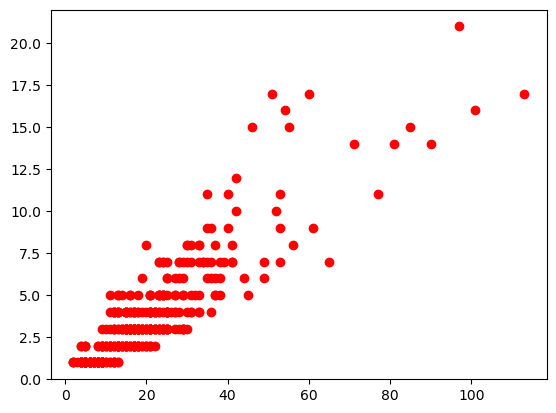

In [71]:
a=e_l_n.get(['comparetype'])
x=[i.get('nof_points') for i in a]
y=[i.get('nof_bezzes') for i in a]
plt.scatter(x,y,color='red')
print(np.mean(x)/np.mean(y))

no descriptiontwo stroke sets only, check for commpression ratio.. before after.. number of points
5.818402777777778


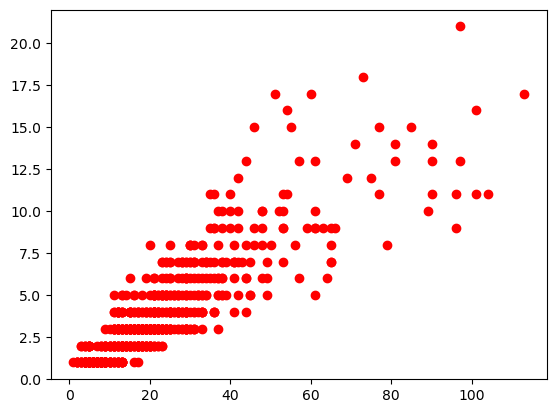

In [187]:
e_l_n=error_log_navigator(error_log)
e_l_n.describe(text='two stroke sets only, check for commpression ratio.. before after.. number of points')

a=e_l_n.get(['comparetype'])
x=[i.get('nof_points') for i in a]
y=[i.get('nof_bezzes') for i in a]
plt.scatter(x,y,color='red')
print(np.mean(x)/np.mean(y))

In [106]:
e_l_n2=error_log_navigator(error_log)
e_l_n2.describe(text='error log updated, plug type has new k:v "self.p"')

selfps=e_l_n2.get_selfps()
#selfps=selfps.values()
'''dic={}
for i in selfps:
    a,b=i
    if a not in dic.keys():
        dic[a]=[b]
    else:
        dic[a].append(b)
selfps=dic.values()'''

no descriptionerror log updated, plug type has new k:v "self.p"


In [115]:
e_l_n3=error_log_navigator(error_log)
e_l_n3.describe(text='I want to see why there is a div by zero error')

divby0=e_l_n3.get_divby0()
divby0

no descriptionI want to see why there is a div by zero error


[{'d32': 0.0,
  'd30': 0.0,
  'p32': array([0., 0.]),
  'p30': array([0., 0.]),
  'p[2]': array([0.35579254, 0.68891769]),
  'p[0]': array([0.35579254, 0.68891769]),
  'p[3]': array([0.35579254, 0.68891769]),
  'a0': 0.35579253514299564,
  'a1': 0.0,
  'a2': 0.0,
  'a3': 0.0},
 {'d32': 0.0,
  'd30': 0.0,
  'p32': array([0., 0.]),
  'p30': array([0., 0.]),
  'p[2]': array([0.35579254, 0.68891769]),
  'p[0]': array([0.35579254, 0.68891769]),
  'p[3]': array([0.35579254, 0.68891769]),
  'a0': 0.35579253514299564,
  'a1': 0.0,
  'a2': 0.0,
  'a3': 0.0}]

In [150]:
e_l_n3=error_log_navigator(error_log)
e_l_n3.describe(text='I want to see why there is a div by zero error')

divby0=e_l_n3.get_divby0()
divby0

no descriptionI want to see why there is a div by zero error


[{'d32': 0.0,
  'd30': 0.0,
  'p32': array([0., 0.]),
  'p30': array([0., 0.]),
  'p[2]': array([0.35579254, 0.68891769]),
  'p[0]': array([0.35579254, 0.68891769]),
  'p[3]': array([0.35579254, 0.68891769]),
  'a0': 0.35579253514299564,
  'a1': 0.0,
  'a2': 0.0,
  'a3': 0.0,
  'self.stroke is singleton?': array([[0.35579254, 0.68891769, 0.59867198]])},
 {'d32': 0.0,
  'd30': 0.0,
  'p32': array([0., 0.]),
  'p30': array([0., 0.]),
  'p[2]': array([0.35579254, 0.68891769]),
  'p[0]': array([0.35579254, 0.68891769]),
  'p[3]': array([0.35579254, 0.68891769]),
  'a0': 0.35579253514299564,
  'a1': 0.0,
  'a2': 0.0,
  'a3': 0.0,
  'self.stroke is singleton?': array([[0.35579254, 0.68891769, 0.59867198]])}]

In [143]:
intere=[i for i in error_log if i.get('type')=='interesting']#'type':'interesting'
intere

[]

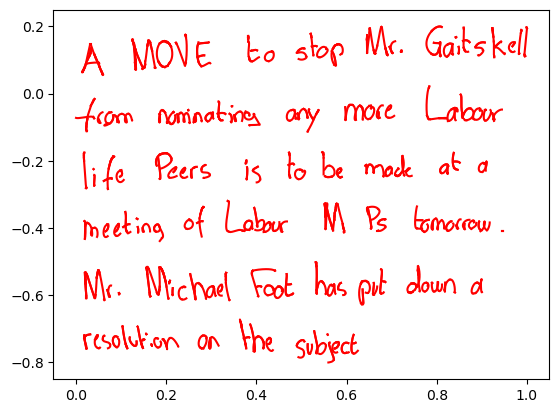

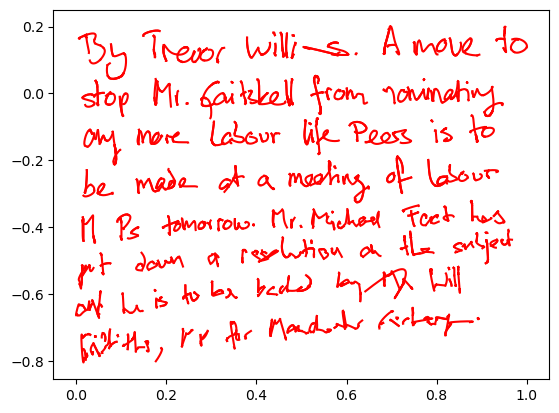

In [109]:
class tiny_bez():
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')
        

for s in selfps:
    for i in s:
        
        a,b,c,d=i
        t_b=tiny_bez(a,b,c,d)
        t_b.show()
    plt.show()


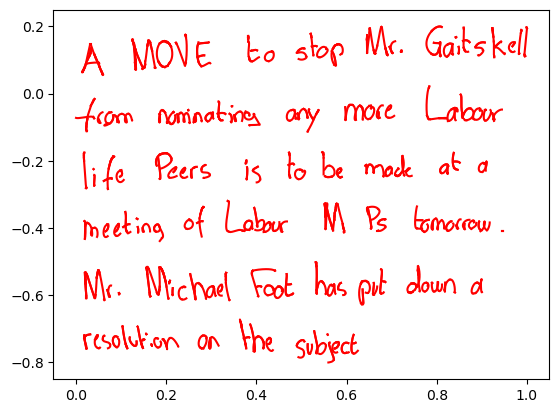

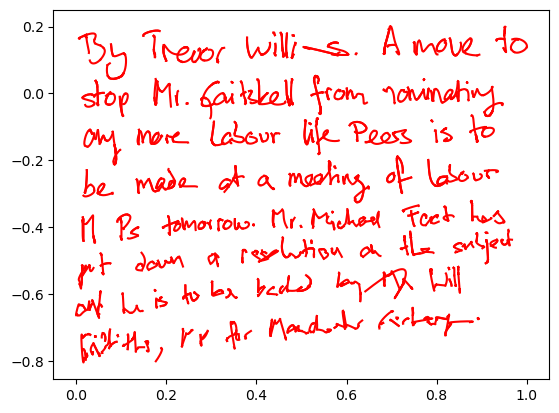

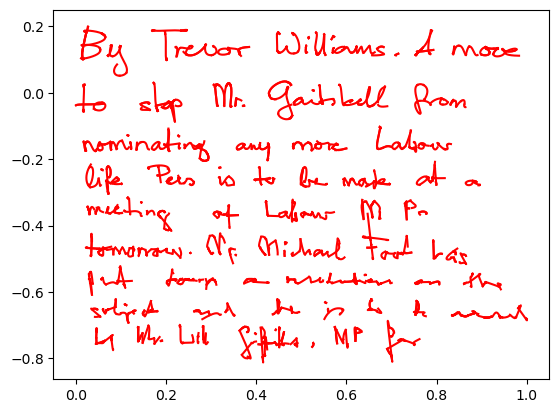

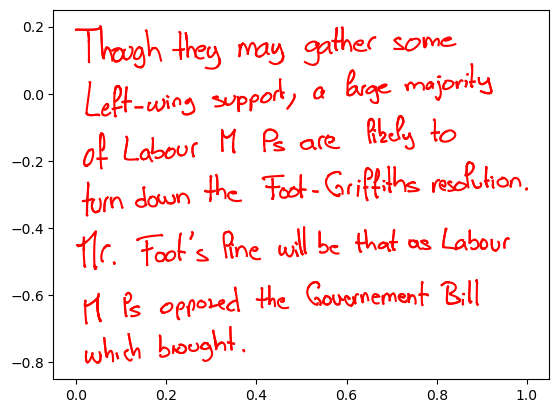

In [132]:
class tiny_bez():
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')

e_l_n3=error_log_navigator(error_log)        
selfps=e_l_n3.get_selfps()
for s in selfps:
    for i in s:
        
        a,b,c,d=i
        t_b=tiny_bez(a,b,c,d)
        t_b.show()
    plt.show()




In [215]:
lis=[]
for i,thing in enumerate(error_log):
    t1='ss,stype'
    gt=thing.get('type')
    gss=thing.get('stroke_set')
    gs=thing.get('stroke')
    if gt==t1 and( gss in [0,1,2,3]) and gs==0:
        lis.append(i)
print(lis)
'''position of the first error_log entry for StrokeSet 0,1 and 2 [0, 1159, 2688]
this will be useful to find the length of each stroke in that StrokeSet'''

lis0=[{'0':[]},{'1':[]},{'2':[]}]

for i,thing in enumerate(lis[:-1]):
    for j in error_log[thing:lis[i+1]]:
        if j.get('type')=='plugtype':
            lis0[i][str(i)].append(j.get('plugged_length'))
                
'''lis0 will have the stroke lengths for all strokes in StrokeSets concerned'''  
        # length of s in the first ss,{},{}
#lis0={0:[length,length,,,]},{1:[l,l,l,,,,,]},{2:}



[0, 1159, 2688]


In [226]:
lengths=lis0[0]['0'] #len(S) for S in SS[0]
print(len([i for i in lengths if i==2])/len(lengths))

''' 43% of SS[0] is composed of strokes-of-length-2'''

0.43954802259887005


In [220]:
'''for i,thing in enumerate(lis0[:-1]):
    plt.hist(thing[str(i)],bins=20)
    plt.show()'''

for i,thing in enumerate(lis0[:-1]):
    print(np.sum(thing.get(str(i)))) 
'''cumulative number of points in each strokeSet after Bezifying
strokeSet 0: 3886 strokeSet 1:5741'''

3886
5741


In [225]:
label=mapped_l_ss[:2].copy()
for i in label:
    j=0
    strokeset=i[1]
    for stroke in strokeset:
        for point in stroke:
            j=j+1 
    print(j)
    '''cumulative number of points in each strokeSet BEFORE bezifying
strokeSet 0: 3224 strokeSet 1:4783'''
    
''' this is bad,  the number of points used to be fewer before bezzing-compression?'''

3224
4783


In [229]:
unique, counts = np.unique(lis0[0]['0'], return_counts=True)
hist=dict(zip(unique,counts))
hist
''' this is the histogram of LENGTH vs. COUNT OF STROKES WITH THAT LENGTH'''
'''this is after bezified, before any stitching...'''

{2: 389,
 3: 83,
 4: 62,
 5: 66,
 6: 63,
 7: 71,
 8: 50,
 9: 42,
 10: 33,
 11: 17,
 12: 6,
 13: 3}

mean: 4.688973063973064


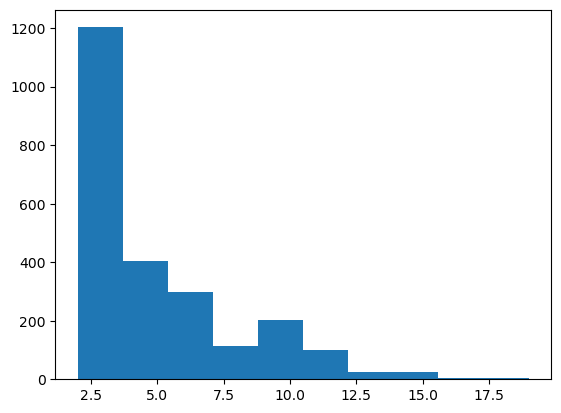

In [192]:
# error_log.append({'type':'plugtype','plugged_length':len(self.bezier_beads)})
a=[]
for i in error_log:
    if i.get('type')=='plugtype':
        a.append(i.get('plugged_length'))

plt.hist(a,bins=10)
print('mean:',np.mean(a))

'asdf'

<class 'numpy.ndarray'>


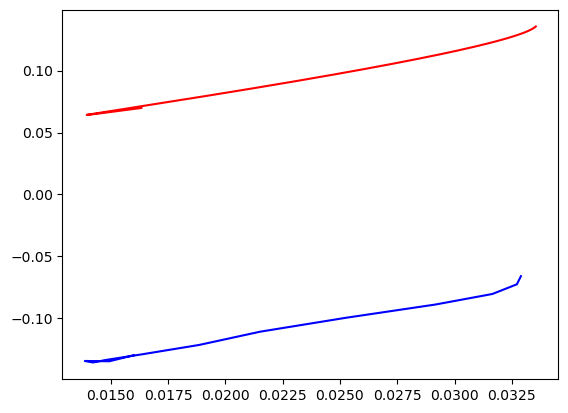

In [180]:
dic=error_log[-1]
stroke=dic.get('stroke')
print(type(stroke)) #nd array?
my_p=dic.get('bez') #self.p's plot with tiny bez

class tiny_bez(): #plots bezier given [p0 p1 p2 p3]
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')
a,b,c,d=my_p
t_b=tiny_bez(a,b,c,d)
t_b.show()
x=stroke[:,0]
y=stroke[:,1]*-1
plt.plot(x,y,color='blue') #blue is ground truth, red is the bezier
plt.show()

a=[]
b=[]
for i in error_log:
    if i.get('type')=='bendytype':
        a.append(i.get('min_BBA')==i.get('first_BBA'))
        b.append(i.get('min_BBA'))
        
        
        

print('anomaly: min not first: ',np.sum(a))
print('maximum, BBA min, ie wasted bez space[1,0]: ',max(b)) # 0.35968231586605576

for i,thing in enumerate(error_log):
    if thing.get('type')=='bendytype':
        if thing.get('min_BBA')==max(b):
            for j in error_log[:i:-1]:
                if  j.get('type')=='ss,stype':
                    print(j)
                    sys.exit()
                    
'''anomaly: min not first:  157
maximum, BBA min, ie wasted bez space[1,0]:  0.35968231586605576
{'type': 'ss,stype', 'stroke_set': 1, 'stroke': 135}
An exception has occurred, use %tb to see the full traceback.

SystemExit
'''

In [200]:
for i in [0,1,2,3][:-1]:
    print(i)

0
1
2


In [ ]:

class tiny_bez(): #plots bezier given [p0 p1 p2 p3]
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')
def legibilitytest(shift): 
    # fake_p_list is a list of self.p's ....R4,2  
    for p in fake_p_list:
        p1,p2,p3,p4=p[0]
        '''p1 = np.array([0.05903272, 0.14191661])
        p2 = np.array([0.05866016, 0.13978588])
        p3 = np.array([0.05798279, 0.13681332])
        p4 = np.array([0.05618777, 0.13240673])'''
        t_b=tiny_bez(p1,p2,p3,p4)
        t_b.show(shift=shift)




    s=[]
    for stroke in sstesting[0][1][:50]:
        ss=[np.array(point[:2]) for point in stroke]
        ss=np.array(ss)
        s.append(ss)
    for s in s:
        s=np.array(s)
        x_scale,y_scale=1,-1
        sx=s[:,0]*x_scale
        sy=s[:,1]*y_scale
        plt.plot(sx,sy,color='green')
    plt.show()

 number of individual strokesets, ie length of dataset: 1730
303676
total number of strokes in the dataset: 303676


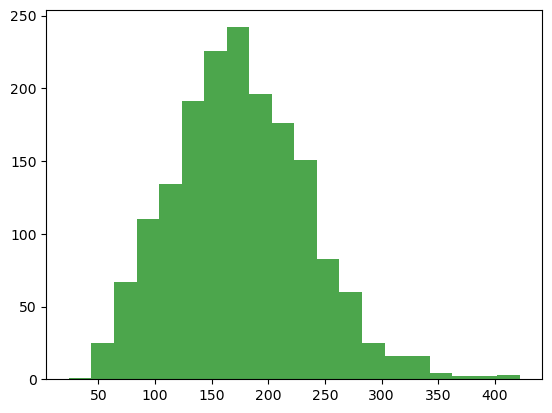

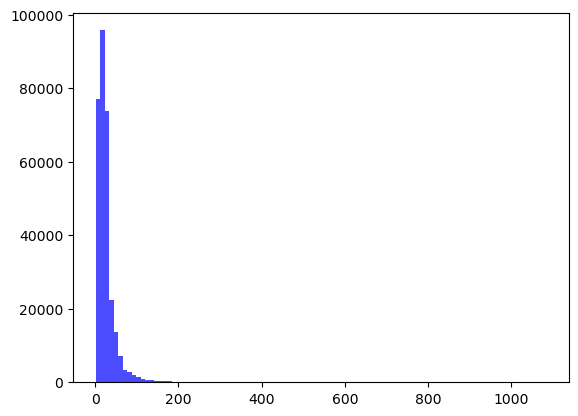

avg set_size: 175.53526011560695
avg stroke_size: 25.21393524677617
number of single point strokes: 3938


In [164]:
a=mapped_l_ss.copy()
print(' number of individual strokesets, ie length of dataset:',len(a))
no_s=0
set_size=[]
stroke_size=[]
for i,(_,strokeset) in enumerate(a):
    set_size.append(len(strokeset)) # number of strokes you can expect
    for j,stroke in enumerate(strokeset):
        stroke_size.append(len(stroke)) # number of points you can expect
        no_s+=1
print(no_s)
print('total number of strokes in the dataset:',len(stroke_size))
plt.hist(set_size, bins=20, color='green', alpha=0.7)
plt.show()
plt.hist(stroke_size, bins=100, color='blue', alpha=0.7)
plt.show()

print('avg set_size:',np.mean(set_size))
print('avg stroke_size:',np.mean(stroke_size))

print('number of single point strokes:',len([i for i in stroke_size if i==1]))

In [ ]:
len(mapped_l_ss2)

In [121]:
len(fake_p_list)

0

In [138]:
p1,p0,p3=[0.27880512, 0.28163862],[0.27862731, 0.28188247], [0.2784495,  0.28212631] 
p1,p0,p3=[np.array(i) for i in [p1,p0,p3]]
p10,p03=p1-p0,p0-p3
d10,d03=(np.sum(p10**2))**0.5,(np.sum(p03**2))**0.5
print(d10*d03 ==0 )
print(np.sum(p10*p03)/(d10*d03)>1)
print(np.sum(p10*p03)/(d10*d03)<-1)

print('\n p10, p03:',p10,p03)
print('\n d10, d03:',d10,d03)

print('\n smol?:',p1-p3)

False
False
False

 p10, p03: [ 0.00017781 -0.00024385] [ 0.00017781 -0.00024384]

 d10, d03: 0.0003017933375672751 0.0003017852575922121

 smol?: [ 0.00035562 -0.00048769]


In [66]:
thing=[1,2,3]
deduplicated=[[],[],[1,2,3]]
thing=np.array(thing)
deduplicated=np.array(deduplicated)
if (thing[:2]==deduplicated[-1][:2]).all:
    
    print('asdfa')

asdfa


C:\Users\adith\AppData\Local\Temp\ipykernel_26884\992300625.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  deduplicated=np.array(deduplicated)


# below are just experiments::::

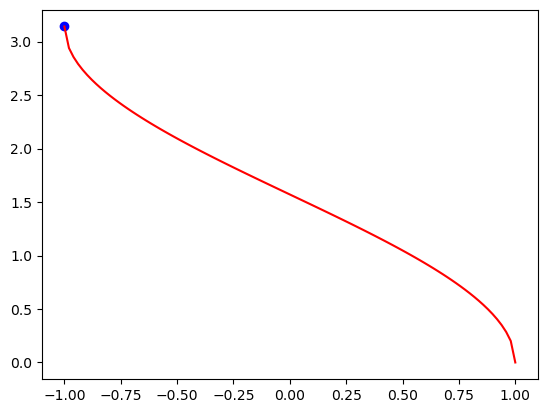

In [155]:
p0=np.array([0,0])
p1=np.array([1,1])
p2= -1*p1
#antiparallel vectors
p01=p1-p0
p02=p2-p0
d01=np.sum(p01**2)**0.5
d02=np.sum(p02**2)**0.5
val=np.sum(p01*p02)/(d01*d02)
get=math.acos(val)
plt.scatter(val,get,color='blue')
 # 180 degrees is pi... always taking the smaller angle.... 
x=np.linspace(1,-1,100)
y=[math.acos(i) for i in x]
plt.plot(x,y,color='red')

#deletabe cell

'''mapped_l_bs=[mapped_l_ss.copy()[0]] #this will be referred
mapped_l_bs2=[mapped_l_ss.copy()[0]]'''

sstesting=[list(mapped_l_ss.copy()[0])]
sstesting[0][1]=sstesting[0][1][:50]

'''mapped_l_bs= refferrant.copy()
mapped_l_bs2=refferrant.copy()'''

mapped_l_bs= sstesting.copy()
mapped_l_bs2=sstesting.copy()

fake_p_list=[]
# </deletable cell>

for i,(_,strokeset) in enumerate(mapped_l_bs):
    for j,stroke in enumerate(strokeset):
        mapped_l_bs2[i]=list(mapped_l_bs2[i])
        mapped_l_bs2[i][1]=[]
        b_z=B_Z() #flush bezier_class' variables every stroke..
        # something from here must be a function to call in recursion
        b_z.stroke_matrix,stroke_length=b_z.strokelength(stroke)
        start_time=b_z.stroke_matrix[0][2]
        time_range=b_z.stroke_matrix[-1][2]-start_time#tfinal-t0
        for k,point in enumerate(stroke):
            b_z.stroke_matrix[k][2]=((point[2]-start_time)/time_range)*stroke_length
        print('current stroke number is: ','「',j,'」')
        locp,fake_p=b_z.bezify()###
        #fake_locp=b_z.fake_bezify()###
        locp[0][-1]=0 #first point starts with pen up (ie: 0)
        mapped_l_bs2[i][1].extend(locp)#bezify will return a list of 10d points.. usually just one 10d point
        fake_p_list.extend(fake_p)###

fake_p_list #len=8

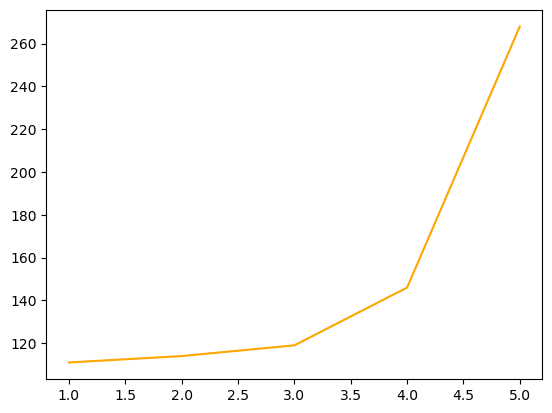

In [27]:
y=[111,114,119,146,268]
x=np.array(range(5))+1
plt.plot(x,y,color='orange')

 ## stop running here

 ## stop running here, >:(

In [603]:
mapped_l_bs2

[['A MOVE to stop Mr . Gaitskell from nomnating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow Mr . Michael Foot has put down a resolution on the subject',
  [array([ 1.15082187e-02,  1.74173547e-03,  2.84231754e-03,  4.82514120e-03,
           2.48304334e+00,  2.74917106e+00,  1.61659604e-02, -5.90357655e-03,
           1.72187649e-03,  0.00000000e+00])]]]

In [604]:
points=refferrant[0][1][0]#first stroke.... list of points

In [392]:
for i,thing in enumerate(points[:-1]):
    x,y,_=thing
    x1,y1,_=points[i+1]
    if x==x1 and y==y1:
        print('flag')
        
    

flag


In [ ]:
points

In [ ]:
refferrant

In [77]:
mapped_l_bs2

[['testing',
  [array([ 0.01280228, -0.04023409,  0.01399987,  0.00805316,  3.02581736,
           3.09756748,  0.07981695, -0.11268275,  0.07512183,  0.        ])]]]

# this is to viz the ground vs bezzed writing; is the compression ok?

In [84]:

class tiny_bez():
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')
def legibilitytest(shift): 
    # fake_p_list is a list of self.p's ....R4,2  
    for p in fake_p_list:
        p1,p2,p3,p4=p[0]
        '''p1 = np.array([0.05903272, 0.14191661])
        p2 = np.array([0.05866016, 0.13978588])
        p3 = np.array([0.05798279, 0.13681332])
        p4 = np.array([0.05618777, 0.13240673])'''
        t_b=tiny_bez(p1,p2,p3,p4)
        t_b.show(shift=shift)




    s=[]
    for stroke in sstesting[0][1][:50]:
        ss=[]
        for point in stroke:
            ss.append(np.array(point[:2]))
        ss=np.array(ss)
        s.append(ss)
    for s in s:
        s=np.array(s)
        x_scale,y_scale=1,-1
        sx=s[:,0]*x_scale
        sy=s[:,1]*y_scale
        plt.plot(sx,sy,color='green')
    plt.show()

 ## stop running!

 ## stop running!

 ## stop running!

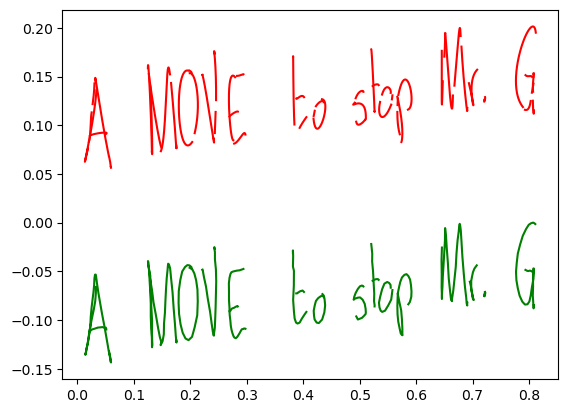

In [560]:
legibilitytest()#SSEmaxThr=1e-4

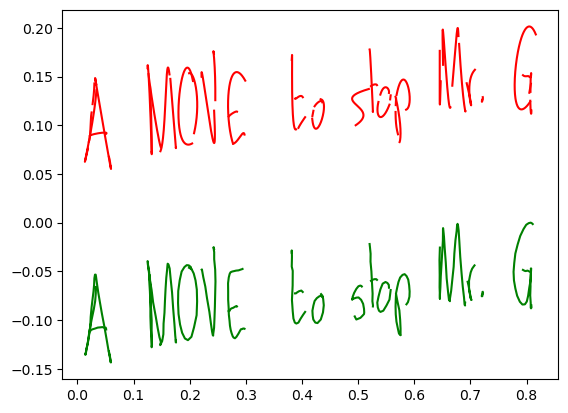

In [568]:
legibilitytest()#SSEmaxThr=1e-3

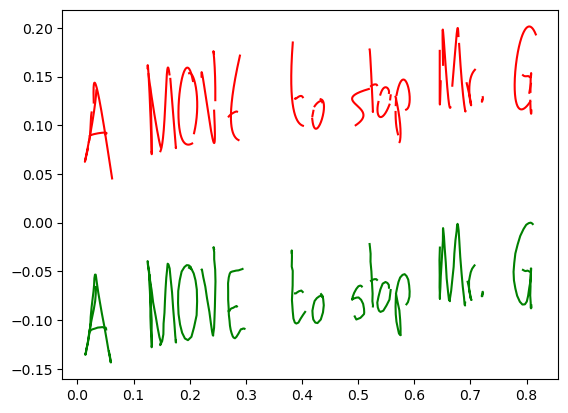

In [576]:
legibilitytest()#SSEmaxThr=1e-2

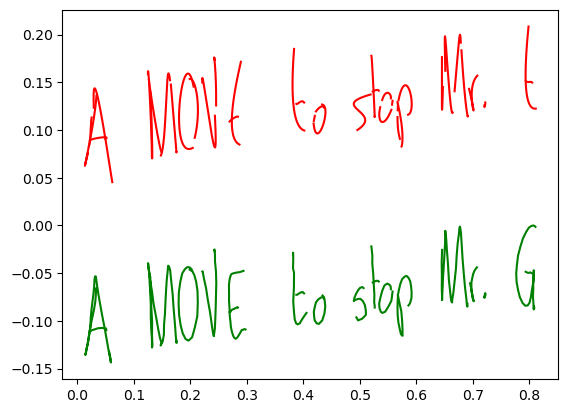

In [583]:
legibilitytest()#SSEmaxThr=1e-1

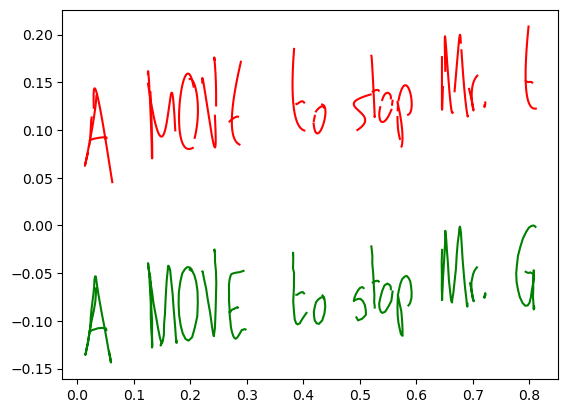

In [591]:
legibilitytest()#SSEmaxThr=1e-0

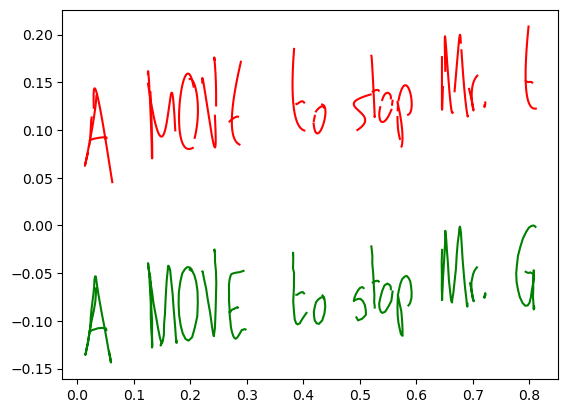

In [597]:
legibilitytest()#SSEmaxThr=0.9

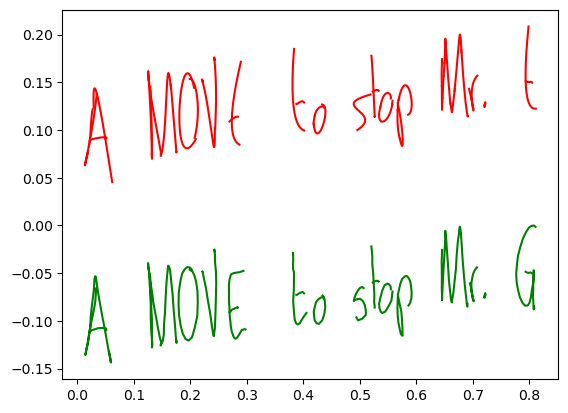

In [605]:
legibilitytest()#SSEmaxThr=1e-1 
#cuts are readjusted

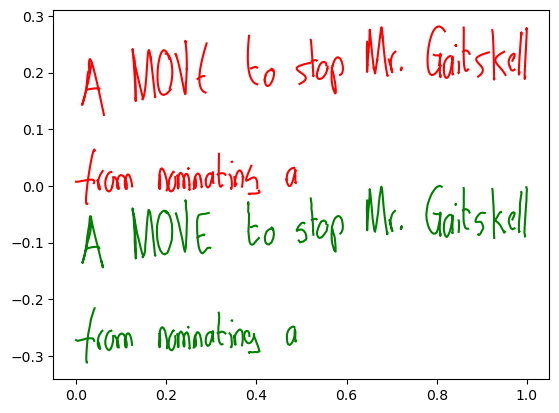

In [622]:
legibilitytest(shift=0.4)#SSEmaxThr=1e-2
#cuts are readjusted
#number of strokes 20->50

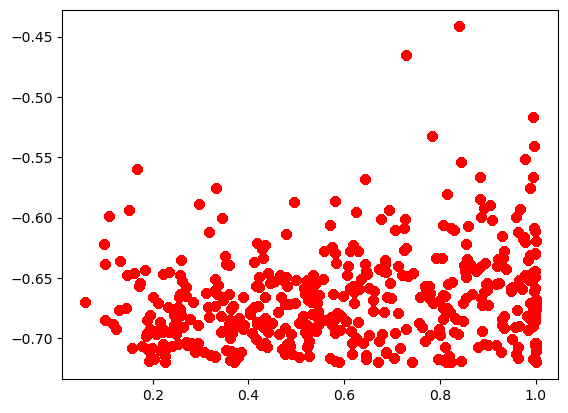

In [100]:

class tiny_bez():
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red',shift=0):
        l=self.lin_space()
        #print(l)
        lx=l[:,0]
        ly=(l[:,1]*-1)+0.2+0.2*shift
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        #plt.scatter(sx,sy,color='blue')
def legibilitytest(shift,fake_p_list): 
    # fake_p_list is a list of self.p's ....R4,2  
    for p in fake_p_list:
        p1,p2,p3,p4=p[0]
        #print(p1,p2,p3,p4)
        '''p1 = np.array([0.05903272, 0.14191661])
        p2 = np.array([0.05866016, 0.13978588])
        p3 = np.array([0.05798279, 0.13681332])
        p4 = np.array([0.05618777, 0.13240673])'''
        t_b=tiny_bez(p1,p2,p3,p4)
        t_b.show(shift=shift)




    '''s=[]
    for stroke in sstesting[0][1][:50]:
        ss=[]
        for point in stroke:
            ss.append(np.array(point[:2]))
        ss=np.array(ss)
        s.append(ss)
    for s in s:
        s=np.array(s)
        x_scale,y_scale=1,-1
        sx=s[:,0]*x_scale
        sy=s[:,1]*y_scale
        plt.plot(sx,sy,color='green')'''
    plt.show()

legibilitytest(shift=0.4,fake_p_list=fake_p_list)#SSEmaxThr=1e-3
#cuts are readjusted
#number of strokes 20->50

In [92]:
for p in fake_p_list:
    print(len(p[0]))
fake_p_list

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


[[array([[0.62002134, 0.94123385],
         [0.62002134, 0.94123385],
         [0.62002134, 0.94123385],
         [0.62002134, 0.94123385]])],
 [array([[0.89195402, 0.8719865 ],
         [0.89195402, 0.8719865 ],
         [0.89195402, 0.8719865 ],
         [0.89195402, 0.8719865 ]])],
 [array([[0.69655841, 0.93376539],
         [0.69655841, 0.93376539],
         [0.69655841, 0.93376539],
         [0.69655841, 0.93376539]])],
 [array([[0.37239165, 0.96594503],
         [0.37239165, 0.96594503],
         [0.37239165, 0.96594503],
         [0.37239165, 0.96594503]])],
 [array([[0.69299604, 0.87406816],
         [0.69299604, 0.87406816],
         [0.69299604, 0.87406816],
         [0.69299604, 0.87406816]])],
 [array([[0.32916743, 0.93986928],
         [0.32916743, 0.93986928],
         [0.32916743, 0.93986928],
         [0.32916743, 0.93986928]])],
 [array([[0.36983221, 1.        ],
         [0.36983221, 1.        ],
         [0.36983221, 1.        ],
         [0.36983221, 1.        ]])],

In [1]:
legibilitytest(shift=0.4)#SSEmaxThr=1e-3
#cuts are readjusted
#number of strokes 20->50

length of ref: 1 ,type of ref: <class 'list'>
length of ref[0]: 2 ,type of ref[0]: <class 'tuple'>
length of ref[0][1]: 180 ,type of ref[0][1]: <class 'list'>
length of ref[0][1][0]: 40 ,type of ref[0][1][0]: <class 'list'>
length of ref[0][1][0][0]: 3 ,type of ref[0][1][0][0]: <class 'tuple'>
behold,the 3 element tuple: ('0.0329', '0.0661', '0.0000')


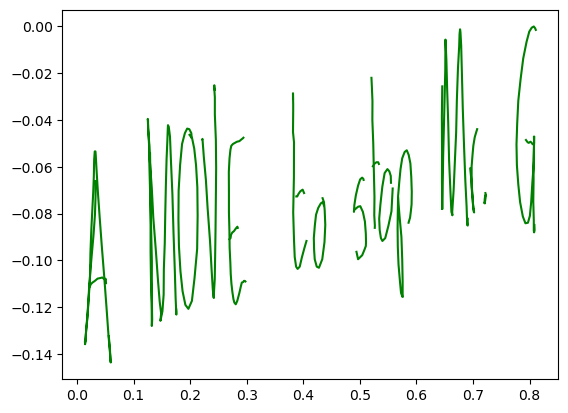

In [556]:
def tell_me_info(ref,more=False):
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref:',l,',type of ref:',t)
    ref=ref[0]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0]:',l,',type of ref[0]:',t)
    ref=ref[1]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0][1]:',l,',type of ref[0][1]:',t)
    ref=ref[0]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0][1][0]:',l,',type of ref[0][1][0]:',t)
    if more:
        ref=ref[0]
        l=str(len(ref))
        t=str(type(ref))
        print('length of ref[0][1][0][0]:',l,',type of ref[0][1][0][0]:',t)
        
        point=tuple(["{:.4f}".format(i) for i in ref])
        print('behold,the 3 element tuple:',str(point))
        

sstesting=[mapped_l_ss.copy()[0]]
tell_me_info(sstesting,more=True)

s=[]
for stroke in sstesting[0][1][:20]:
    ss=[]
    for point in stroke:
        ss.append(np.array(point[:2]))
    ss=np.array(ss)
    s.append(ss)
for s in s:
    s=np.array(s)
    x_scale,y_scale=1,-1
    sx=s[:,0]*x_scale
    sy=s[:,1]*y_scale
    plt.plot(sx,sy,color='green')
plt.show()

In [557]:
a=np.array([1])
b=np.array([2])

In [1]:
a,b=[0.021456925918507185, 0.0007990573516737103]
a-b


0.020657868566833475

In [2]:
1e-4

0.0001

# new experiment, let's take a look at this rebel stroke:

In [195]:
#ParametricPlot[{x(t), y(t)}, {t, 0, 1}]


In [415]:

stroke_tracker=0
flag=True
flag2=True
import tkinter as tk

import random

#xandy=[fortypointstroke[:14]]
xandy=[fortypointstroke]
#xandy=[thing]#expected thing is a list of type [(...),(),(),...]
number_of_colours_printed=0 #out of 100
rcolours=[
"#F0F8FF"
,"#FAEBD7"
,"#00FFFF"
,"#007FFF"
,"#E3CF57"
,"#FFEBCD"
,"#8A2BE2"
,"#CD3333"]

'''scale=1000
scaley=200'''
scale=10000
scaley=2000
class DrawingApp:
    global stroke_tracker, rcolours, scale, scaley,flag, flag2
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Drawing App")

        # Create a Canvas widget to draw on
        self.canvas = tk.Canvas(root, bg="white", width=1400, height=800)
        self.canvas.pack()

        #my addition , deletable
        #self.canvas.bind("<ButtonRelease-1>", self.stop_drawing)

        # Bind mouse events to canvas
        self.canvas.bind("<Button-1>", self.start_drawing)
        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonRelease-1>", self.stop_drawing)

        # Initialize drawing variables
        self.drawing = True
        self.last_x = None
        self.last_y = None
        self.stroke_tracker=stroke_tracker

    def start_drawing(self, event):
        self.drawing = True
        self.last_x = event.x
        self.last_y = event.y
        
    def print_colour(self):
        number_of_colours_printed+=1
        if number_of_colours_printed>=100:
            pass
        else:
            print(self.colour)

    def change_colour(self):
        temp=str(hex(random.randrange(0, 2**24)))
        temp=temp[2:]
        temp='#'+temp
        self.colour= random.choice(rcolours)

    def change_colour_2(self):
        global stroke_tracker
        s=0
        temp=str(hex(random.randrange(0, 2**24)))
        temp=temp[2:]
        temp='#'+temp
        #a[:-2]+hex(random.choice(range(256)))[-2:]
        self.stroke_tracker+=1
        self.stroke_tracker*=(1+0.06*9/40)
        if self.stroke_tracker>=255:
            self.stroke_tracker=0

        if self.stroke_tracker<16:
            s='0'
        else:
            s=''
        '''if not type("#F0F8")==type('s'):
            print('the type of first part #f0f8   :',type("#F0F8"))#++
        if not type(s)==type('s'):    
            print('the type of s   :',type(s))
        if type(s)==type(1):
            print('#########we found a culprit: type of s is int, s is',str(s))
        if not type(hex(stroke_tracker)[2:])==type('s'):
            print('the type of hex(st)[2:]   :',type(hex(stroke_tracker)[2:]))
        if not type(hex(stroke_tracker))==type('s'):
            print('the type of only hex(st)   :',type(hex(stroke_tracker)))
        if hex(stroke_tracker)[2:]==100 or hex(stroke_tracker)[2:]=='100':
            print('###########the hex is 100 why? Ho\'s_t:',hex(stroke_tracker),' s_t: ',str(stroke_tracker))'''
        if "#F0F8"+s+hex(int(self.stroke_tracker))[2:]=="#F0F8100":
            print('something went wrong:')
            print('                            my s_t:',str(int(self.stroke_tracker)))
            print('                            my hex:',hex(int(self.stroke_tracker)))


        self.colour= "#F0"+s+hex(int(self.stroke_tracker))[2:]+s+hex(int(self.stroke_tracker))[2:]
        '''print(stroke_tracker)'''
        self.print_colour()

    def draw(self, event):
        global flag,flag2

        if self.drawing:
            for stroke in xandy:
                #self.change_colour()
                self.colour="#F0F800"
                self.last_x= stroke[0][0]*scale
                self.last_y= stroke[0][1]*scaley
                first_loop=True
                for point in stroke:
                    if first_loop:
                        first_loop=False
                        continue
                    self.change_colour_2()
                    x, y = point[0]*scale,point[1]*scaley
                    self.canvas.create_line(self.last_x, self.last_y, x, y, fill=self.colour, width=2)
                    self.canvas.create_oval(x+10, y+10,x, y, fill=self.colour)
                    if flag2:
                        if self.stroke_tracker>=4:
                            flag2=False
                        self.canvas.create_text(x+15, y+15, text="{:.2f}".format(self.stroke_tracker), font=("Helvetica", 9))

                    if flag:
                        self.canvas.create_oval(x+10, y+10,x, y, fill=self.colour)
                        flag=False
                    self.last_x = x
                    self.last_y = y

    def stop_drawing(self, event):
        self.drawing = False
        self.last_x = None
        self.last_y = None

if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()


#F00101
#F00202
#F00303
#F00404
#F00505
#F00606
#F00707
#F00808
#F00909
#F00a0a
#F00b0b
#F00d0d
#F00e0e
#F00f0f
#F01010
#F01111
#F01313
#F01414
#F01515
#F01717
#F01818
#F01919
#F01b1b
#F01c1c
#F01d1d
#F01f1f
#F02020
#F02222
#F02323
#F02525
#F02626
#F02828
#F02929
#F02b2b
#F02c2c
#F02e2e
#F03030
#F03131
#F03333
#F03535
#F03737
#F03838
#F03a3a
#F03c3c
#F03e3e
#F04040
#F04141
#F04343
#F04545
#F04747
#F04949
#F04b4b
#F04d4d
#F04f4f
#F05151
#F05454
#F05656
#F05858
#F05a5a
#F05c5c
#F05f5f
#F06161
#F06363
#F06666
#F06868
#F06a6a
#F06d6d
#F06f6f
#F07272
#F07474
#F07777
#F07a7a
#F07c7c
#F07f7f
#F08282
#F08484
#F08787
#F08a8a
#F08d8d
#F09090
#F09393
#F09696
#F09999
#F09c9c
#F09f9f
#F0a2a2
#F0a6a6
#F0a9a9
#F0acac
#F0afaf
#F0b3b3
#F0b6b6
#F0baba
#F0bdbd
#F0c1c1
#F0c4c4
#F0c8c8
#F0cccc
#F0d0d0
#F0d3d3
#F0d7d7
#F0dbdb
#F0dfdf
#F0e3e3
#F0e7e7
#F0ebeb
#F0f0f0
#F0f4f4
#F0f8f8
#F0fdfd
#F00000
#F00101
#F00202
#F00303
#F00404
#F00505
#F00606
#F00707
#F00808
#F00909
#F00a0a
#F00b0b
#F00d0d
#F00e0e
#F00f0f


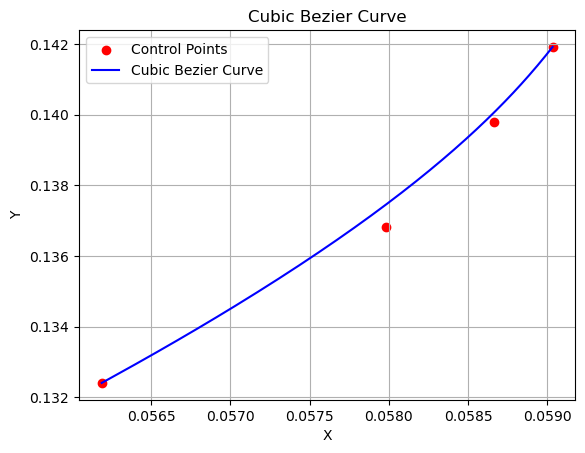

In [297]:
import numpy as np
import matplotlib.pyplot as plt

# Define the control points
p1 = np.array([0.05903272, 0.14191661])
p2 = np.array([0.05866016, 0.13978588])
p3 = np.array([0.05798279, 0.13681332])
p4 = np.array([0.05618777, 0.13240673])

# Generate points on the Bezier curve
tt = np.linspace(0, 1, 150)
curve_points=[]
for t in tt:  
    curve_points.append((1 - t)**3 * p1 + 3 * (1 - t)**2 * t * p2 + 3 * (1 - t) * t**2 * p3 + t**3 * p4)
curve_points=np.array(curve_points)
# Plot the control points and the Bezier curve
plt.scatter([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1],], label="Control Points", color="red")
plt.plot(curve_points[:,0], curve_points[:,1], label="Cubic Bezier Curve", color="blue")
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cubic Bezier Curve')
plt.grid(True)
#scatter plot the real thing:

plt.show()




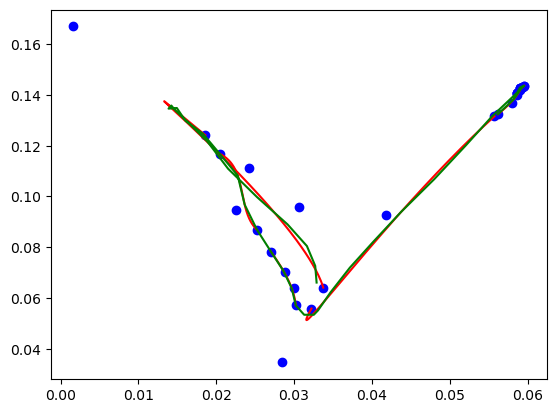

In [504]:

class tiny_bez():
    def __init__(self,p0,p1,p2,p3):
        self.p0=p0
        self.p1=p1
        self.p2=p2
        self.p3=p3
        self.p=np.array([p0,p1,p2,p3])
        
    def bez(self,t):
        return (1 - t)**3 * self.p0 + 3 * (1 - t)**2 * t * self.p1 + 3 * (1 - t) * t**2 * self.p2 + t**3 * self.p3
    
    def lin_space(self):
        lin_space=np.linspace(0, 1, 150)
        return np.array([self.bez(l) for l in lin_space])
    
    def show(self,color='red'):
        l=self.lin_space()
        lx=l[:,0]
        ly=l[:,1]
        plt.plot(lx,ly,color=color)
        s=self.p
        sx=s[:,0]
        sy=s[:,1]
        plt.scatter(sx,sy,color='blue')
        
# fake_p_list is a list of self.p's ....R4,2  
for p in fake_p_list:
    p1,p2,p3,p4=p
    '''p1 = np.array([0.05903272, 0.14191661])
    p2 = np.array([0.05866016, 0.13978588])
    p3 = np.array([0.05798279, 0.13681332])
    p4 = np.array([0.05618777, 0.13240673])'''
    t_b=tiny_bez(p1,p2,p3,p4)
    t_b.show()
    
    
    


s=np.array(fortypointstroke)
sx=s[:,0]
sy=s[:,1]
plt.plot(sx,sy,color='green')
plt.show()

In [505]:
refferrant=[('testing',[[(0.029160739687055477, 0.08900268227261643, 0.0003645909289781842), (0.025248933143669987, 0.0997317727383565, 0.0005104273005691263), (0.0215149359886202, 0.11094854913435748, 0.0005833454863645972), (0.018847795163584636, 0.12167763960009753, 0.0006562636721600683), (0.016358463726884778, 0.12923677151914167, 0.0008021000437510103)]])]

In [508]:
def tell_me_info(ref):
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref:',l,',type of ref:',t)
    ref=ref[0]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0]:',l,',type of ref[0]:',t)
    ref=ref[1]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0][1]:',l,',type of ref[0][1]:',t)
    ref=ref[0]
    l=str(len(ref))
    t=str(type(ref))
    print('length of ref[0][1][0]:',l,',type of ref[0][1][0]:',t)

tell_me_info(refferrant)

length of ref: 1 ,type of ref: <class 'list'>
length of ref[0]: 2 ,type of ref[0]: <class 'tuple'>
length of ref[0][1]: 1 ,type of ref[0][1]: <class 'list'>
length of ref[0][1][0]: 5 ,type of ref[0][1][0]: <class 'list'>


# experiments: